<a href="https://colab.research.google.com/github/Nachos-mic/Rotten_Review_Model/blob/main/EDT_Rotten_Review_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Movie Review Analysis Pipeline
IMDB Sentiment Model + Rotten Tomatoes Fake/Biased Review Detection


#TRENING MODELU 1 - IMDB SENTYMENT

In [1]:
!pip install contractions -qq
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.5 MB/s eta 0:00:00


In [40]:
# Ustawianie środowiska
import pandas as pd
import numpy as np
import re
import string
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.corpus import wordnet

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import contractions
from bs4 import BeautifulSoup
import kagglehub
import os
import glob

# Instalowanie pakietów NLTK
for resource in ['punkt', 'stopwords', 'wordnet', 'punkt_tab', 'averaged_perceptron_tagger', 'averaged_perceptron_tagger_eng']:
    nltk.download(resource, quiet=True)

sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

In [3]:
# Funkcje do czyszczenia datasetu
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def remove_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

def expand_contractions(text):
    return contractions.fix(text)

def to_lowercase(text):
    return text.lower()

def remove_special_characters(text):
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    return text

def remove_extra_spaces(text):
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def remove_stopwords_and_lemmatize(text):
    tokens = word_tokenize(text)
    tokens = [
        lemmatizer.lemmatize(token)
        for token in tokens
        if token not in stop_words and len(token) > 2
    ]
    return " ".join(tokens)

def clean_text(text):
    # Obsługa NaN, None i pustych wartości
    if pd.isna(text) or not isinstance(text, str) or not text.strip():
        return ''

    text = remove_html_tags(text)
    text = expand_contractions(text)
    text = to_lowercase(text)
    text = remove_special_characters(text)
    text = remove_extra_spaces(text)
    text = remove_stopwords_and_lemmatize(text)
    return text

In [4]:
#Przygotowanie datasetu
print("="*60)
print("\nŁadowanie datasetu IMDB...")


dataset_path_imdb = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
csv_path_imdb = os.path.join(dataset_path_imdb, "IMDB Dataset.csv")
df_imdb = pd.read_csv(csv_path_imdb)

print(f"Załadowano recenzje IMDB reviews")
print(f"Podział sentymentu:\n{df_imdb['sentiment'].value_counts()}")

# Przygotowanie datasetu
print("\nCzyszczenie datasetu...")
df_imdb['review_cleaned'] = df_imdb['review'].apply(clean_text)
df_imdb['sentiment_label'] = df_imdb['sentiment'].map({'positive': 1, 'negative': -1})

df_imdb = df_imdb[df_imdb['review_cleaned'].str.strip() != ''].copy()

df_imdb_final = df_imdb[['review_cleaned', 'sentiment_label']].copy()
df_imdb_final = df_imdb_final.rename(columns={'review_cleaned': 'text', 'sentiment_label': 'label'})
df_imdb_final['source'] = 'IMDB'

print(f"\nPrzygotowano dane: {df_imdb_final.shape}")
print(f"Podział etykiet:")
print(df_imdb_final['label'].value_counts())
print(f"Pozytywne (1): {(df_imdb_final['label'] == 1).sum()} ({(df_imdb_final['label'] == 1).sum()/len(df_imdb_final)*100:.1f}%)")
print(f"Negatywne (-1): {(df_imdb_final['label'] == -1).sum()} ({(df_imdb_final['label'] == -1).sum()/len(df_imdb_final)*100:.1f}%)")


Ładowanie datasetu IMDB...
Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
Załadowano recenzje IMDB reviews
Podział sentymentu:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Czyszczenie datasetu...

Przygotowano dane: (50000, 3)
Podział etykiet:
label
 1    25000
-1    25000
Name: count, dtype: int64
Pozytywne (1): 25000 (50.0%)
Negatywne (-1): 25000 (50.0%)


In [5]:
# Ładowanie datasetu Rotten Tomatoes
print("Ładowanie datasetu Clapper Rotten Tomatoes")

dataset_path_clapper = kagglehub.dataset_download(
    "andrezaza/clapper-massive-rotten-tomatoes-movies-and-reviews"
)

csv_files = glob.glob(os.path.join(dataset_path_clapper, "*.csv"))
print(f"Znaleziono pliki: {[os.path.basename(f) for f in csv_files]}")

reviews_file = None
for f in csv_files:
    fname = os.path.basename(f).lower()
    if 'review' in fname and 'movie' not in fname:
        reviews_file = f
        break
    elif 'movie_review' in fname:
        reviews_file = f
        break

if not reviews_file and csv_files:
    for f in csv_files:
        if 'review' in os.path.basename(f).lower():
            reviews_file = f
            break
    if not reviews_file:
        reviews_file = csv_files[0]

df_clapper = pd.read_csv(reviews_file)

# Filtracja top-krytyków
top_critic_col = None
for col in df_clapper.columns:
    col_lower = col.lower().replace('_', '').replace(' ', '')
    if 'topcritic' in col_lower or 'istopdcritic' in col_lower:
        top_critic_col = col
        break

if top_critic_col:
    print(f"\nFiltracja top-krytyków (przed: {len(df_clapper)})")
    df_clapper = df_clapper[
        (df_clapper[top_critic_col] == True) |
        (df_clapper[top_critic_col] == 1) |
        (df_clapper[top_critic_col] == 'True') |
        (df_clapper[top_critic_col] == 'true')
    ].copy()
    print(f"   Po filtracji: {len(df_clapper)}")
else:
    print("\nKolumna top-krytyków nie znaleziona - używam wszystkich recenzji")

# Detekcja kolumn
text_col = None
label_col = None
score_sentiment_col = None

for col in df_clapper.columns:
    col_lower = col.lower().replace('_', '').replace(' ', '')

    if any(x in col_lower for x in ['reviewtext', 'text', 'content']):
        if text_col is None:
            text_col = col

    if any(x in col_lower for x in ['reviewstate', 'state', 'type']):
        if 'score' not in col_lower:
            label_col = col

    if 'scoresentiment' in col_lower or ('score' in col_lower and 'sentiment' in col_lower):
        score_sentiment_col = col

if score_sentiment_col:
    df_clapper = df_clapper.drop(columns=[score_sentiment_col])

if text_col is None or label_col is None:
    raise ValueError("Nie znaleziono wymaganych kolumn text/label")

# Czyszczenie tekstu
print(f"\nCzyszczenie tekstu (przed: {len(df_clapper)})")
df_clapper = df_clapper[df_clapper[text_col].notna()].copy()
df_clapper['text_cleaned'] = df_clapper[text_col].apply(clean_text)
df_clapper = df_clapper[df_clapper['text_cleaned'].str.strip() != ''].copy()
print(f"   Po czyszczeniu: {len(df_clapper)}")

# Mapowanie etykiet
def map_rt_sentiment(val):
    if pd.isna(val):
        return None
    val_str = str(val).lower().strip()
    if val_str in ['fresh', 'positive', '1', 'pos']:
        return 1
    elif val_str in ['rotten', 'negative', '0', 'neg']:
        return -1
    else:
        return None

df_clapper['sentiment_label'] = df_clapper[label_col].apply(map_rt_sentiment)
df_clapper = df_clapper.dropna(subset=['sentiment_label']).copy()

# Finalne przygotowanie
df_clapper_final = df_clapper[['text_cleaned', 'sentiment_label']].copy()
df_clapper_final = df_clapper_final.rename(columns={'text_cleaned': 'text', 'sentiment_label': 'label'})
df_clapper_final['label'] = df_clapper_final['label'].astype(int)
df_clapper_final['source'] = 'Clapper_RT'

print(f"\nClapper RT przygotowany: {df_clapper_final.shape}")
print(f"   Podział etykiet: {df_clapper_final['label'].value_counts().to_dict()}")

Ładowanie datasetu Clapper Rotten Tomatoes


100%|██████████| 152M/152M [00:00<00:00, 219MB/s]

Extracting files...


Znaleziono pliki: ['rotten_tomatoes_movies.csv', 'rotten_tomatoes_movie_reviews.csv']

Filtracja top-krytyków (przed: 1444963)
   Po filtracji: 436807

Czyszczenie tekstu (przed: 436807)
   Po czyszczeniu: 426268

Clapper RT przygotowany: (426268, 3)
   Podział etykiet: {1: 269728, -1: 156540}


In [6]:
#Łączenie datasetu IMDB i Rotten
print("Łączenie datasetu")

# Połącz oba datasety
df_combined = pd.concat([df_imdb_final, df_clapper_final], ignore_index=True)

# Usuń duplikaty tekstowe
print(f"\nUsuwanie duplikatów...")
original_size = len(df_combined)
df_combined = df_combined.drop_duplicates(subset=['text'], keep='first')
duplicates_removed = original_size - len(df_combined)
print(f"Usunięto {duplicates_removed} duplikatów ({duplicates_removed/original_size*100:.1f}%)")

# Losowe przemieszanie
df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nPołączony dataset: {df_combined.shape}")
print("\nPodział datasetu:")
print(f"  IMDB: {(df_combined['source'] == 'IMDB').sum()}")
print(f"  Clapper RT: {(df_combined['source'] == 'Clapper_RT').sum()}")


Łączenie datasetu

Usuwanie duplikatów...
Usunięto 5391 duplikatów (1.1%)

Połączony dataset: (470877, 3)

Podział datasetu:
  IMDB: 49574
  Clapper RT: 421303


Trening modelu

Wektoryzacja tekstu...

Statystyki podziału na zbiory:
   Treningowy: 376701
   Testowy: 94176
   Podział etykiet: {1: 233106, -1: 143595}

Ewaluacja modelu...
   Train Accuracy: 0.8173
   Test Accuracy:  0.8015
               precision    recall  f1-score   support

Negative (-1)       0.77      0.68      0.72     35899
 Positive (1)       0.82      0.87      0.85     58277

     accuracy                           0.80     94176
    macro avg       0.79      0.78      0.78     94176
 weighted avg       0.80      0.80      0.80     94176



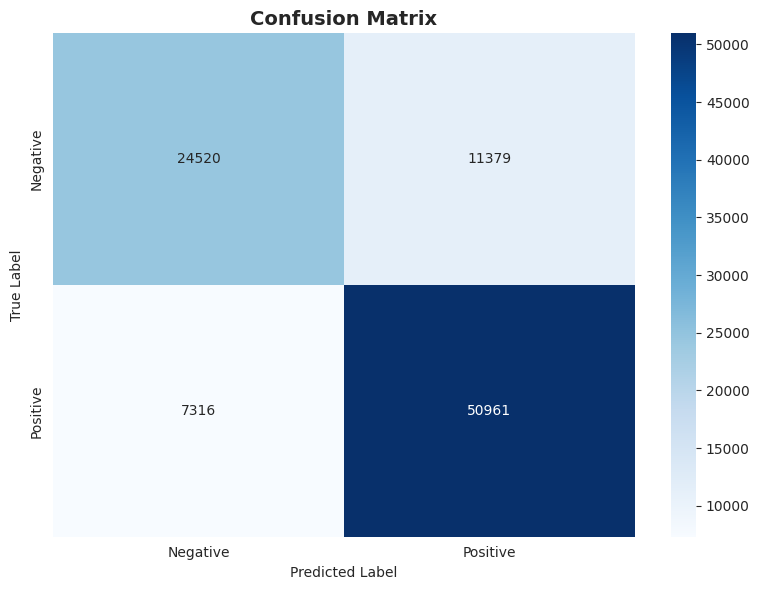

In [7]:
#Trening datasetu
print("Trening modelu")

print("\nWektoryzacja tekstu...")
vectorizer = CountVectorizer(max_features=10000, ngram_range=(1, 2), min_df=2)
X = vectorizer.fit_transform(df_combined['text'])
y = df_combined['label']

# Podział na zbiory train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nStatystyki podziału na zbiory:")
print(f"   Treningowy: {X_train.shape[0]}")
print(f"   Testowy: {X_test.shape[0]}")
print(f"   Podział etykiet: {pd.Series(y_train).value_counts().to_dict()}")

# Trenowanie
model = LogisticRegression(max_iter=1000, random_state=42, C=1.0)
model.fit(X_train, y_train)

# Ewaluacja
print("\nEwaluacja modelu...")
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

print(f"   Train Accuracy: {train_acc:.4f}")
print(f"   Test Accuracy:  {test_acc:.4f}")


print(classification_report(y_test, y_pred_test,
                          target_names=['Negative (-1)', 'Positive (1)']))

#Macierz pomyłek
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix',
          fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


In [28]:
def predict_sentiment(review_text):
    """Funkcja do predykcji sentymentu (pozytywne 1, negatywne -1)"""
    cleaned = clean_text(review_text)
    vector = vectorizer.transform([cleaned])
    return model.predict(vector)[0]

# MODEL 2 - BIAS ROTTEN TOMATOES

EDA & PREPROCESSING

In [8]:
print("Ładowanie datasetu Rotten Tomatoes")

dataset_path_rt = kagglehub.dataset_download(
    "stefanoleone992/rotten-tomatoes-movies-and-critic-reviews-dataset"
)

movies_csv = os.path.join(dataset_path_rt, "rotten_tomatoes_movies.csv")
reviews_csv = os.path.join(dataset_path_rt, "rotten_tomatoes_critic_reviews.csv")

movies_df = pd.read_csv(movies_csv)
reviews_df = pd.read_csv(reviews_csv)

print(f"\nFilmy: {movies_df.shape}")
print(f"\nRecenzje: {reviews_df.shape}")

Ładowanie datasetu Rotten Tomatoes


100%|██████████| 77.2M/77.2M [00:00<00:00, 139MB/s]

Extracting files...



Filmy: (17712, 22)

Recenzje: (1130017, 8)


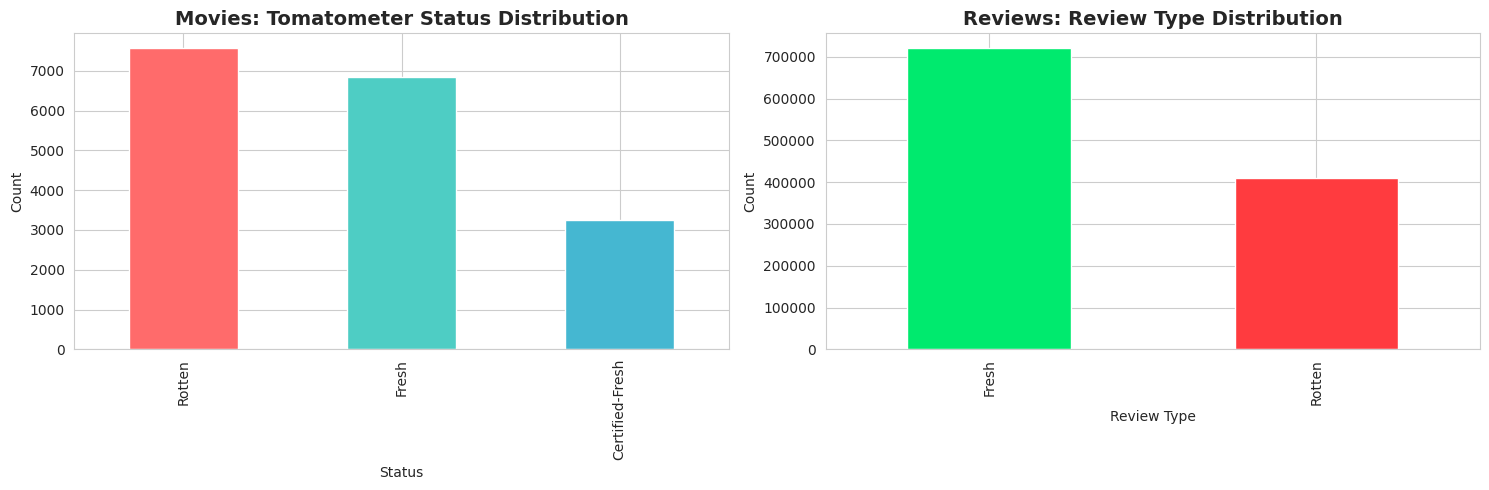

In [9]:
# Analiza rozkładu sentymentu
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

if 'tomatometer_status' in movies_df.columns:
    movies_df['tomatometer_status'].value_counts().plot(kind='bar', ax=axes[0], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    axes[0].set_title('Movies: Tomatometer Status Distribution', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Status')
    axes[0].set_ylabel('Count')

if 'review_type' in reviews_df.columns:
    reviews_df['review_type'].value_counts().plot(kind='bar', ax=axes[1], color=['#00EA6E', '#FF3B3F'])
    axes[1].set_title('Reviews: Review Type Distribution', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Review Type')
    axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [10]:
reviews_df['review_score'].dropna().unique()


array(['3.5/5', '1/4', 'B', '3/5', '4/5', '2/4', '2/5', 'C', '2.5/4',
       '3/4', 'C-', '2.75/5', 'B-', '2.5/5', '5.5/10', '1/5', 'C+', 'D+',
       '1.5/4', '6.5/10', '3/10', '1.5/5', '4/10', '7/10', '6/10', 'B+',
       '5/5', 'A-', '4.5/5', '5.78/10', '3.5/4', 'A', '9/10', '8.5/10',
       '4/4', '83/100', '8/10', '92/100', '82/100', '84/100', '10/10',
       'D-', 'F', '0.5/4', 'D', '5/10', '2/10', '2/6', '0.5/5', '0/4',
       '0/5', '76/100', '87/100', '74/100', '86/100', '81/100', '56/100',
       '78/100', '2.25/5', '8.8/10', '0/10', '44/100', '2.75/4', '2.4/5',
       '8.6/10', '79/100', '68/100', '80/100', '90/100', '66/100',
       '91/100', '0.3/5', '9.2/10', '2.7/5', '57/100', '4/6', '3/6',
       '73/100', '42/100', '65/100', '7.5/10', '4.5/10', '5/6', '1/6',
       '70/100', '3.5/10', '71/100', '0.1/5', '3.25/10', '89/100',
       '40/100', '64/100', '62/100', '1/10', '3.75/5', '37/100', '49/100',
       '60/100', '3.3/5', '77/100', '5.25/10', '1.4/4', '75/100', '1.5/6

In [11]:
# EDA 1: Początkowa eksploracja danych
print("Eksploracja datasetów")

print("\nRecenzje:")
print(f"  Ilość recenzji: {len(reviews_df)}")
print(f"  Brakujące dane:\n{reviews_df.isnull().sum()[reviews_df.isnull().sum() > 0]}")
print(f"\n  Podział recenzentów:")
print(reviews_df['top_critic'].value_counts(dropna=False))

print("\nFilmy:")
print(f"  Ilość filmów: {len(movies_df)}")
#Konwersja  danych z kolumny 'original_release_date' do typu datetime
movies_df['original_release_date'] = pd.to_datetime(movies_df['original_release_date'], errors='coerce')
print(f"  Zakres dat: {movies_df['original_release_date'].min()} - {movies_df['original_release_date'].max()}")

Eksploracja datasetów

Recenzje:
  Ilość recenzji: 1130017
  Brakujące dane:
critic_name        18529
review_score      305936
review_content     65806
dtype: int64

  Podział recenzentów:
top_critic
False    841481
True     288536
Name: count, dtype: int64

Filmy:
  Ilość filmów: 17712
  Zakres dat: 1914-06-01 00:00:00 - 2020-09-30 00:00:00


In [12]:
#Preprocessing danych
print("Filtrowanie top-krytyków")

original_count = len(reviews_df)
reviews_df = reviews_df[reviews_df['top_critic'] == True].copy()
print(f"Po filtracji zostało {len(reviews_df)/original_count*100:.1f}% danych")

Filtrowanie top-krytyków
Po filtracji zostało 25.5% danych


In [13]:
reviews_df['review_score'].dropna().unique()


array(['3.5/5', '3/5', '2/4', '2/5', '3/4', 'C-', '2.5/4', 'C+', 'D+',
       '1/5', 'C', '4/5', 'A-', '4.5/5', '3.5/4', 'A', '1.5/4', '4/4',
       'B', '5/5', '1.5/5', '1/4', 'D', 'F', '2/6', 'B-', '0/4', 'B+',
       'D-', '2.5/5', '0.5/4', '0/5', '2.4/5', '4/6', '3/6', '5/10',
       '5/6', '1/6', '5.5/10', '7/10', '8/10', '6/10', '3/10', '8.5/10',
       '5.9/10', '4.6/10', '3.4/10', '10/10', '0.5/5', '35/100', '1/3',
       '42/100', '9/10', '55/100', '80/100', '78/100', '94/100', '5/100',
       '75/100', '50/100', '30/100', '62/100', '52/100', '3', '2/2',
       '4/10', '3.5/6', '7.5/10', '6.4/10', '4.5/10', '45/100', '70/100',
       '2.5/10', '68/100', '15/100', '0', '0.5/10', '2', '0/6', '0/10',
       '1/10', '8.3/10', '8.1/10', '3.5/10', '1.2/10', '5.2/10', '6.5/10',
       '6.2/10', '47/100', '4.2/10', '9.1/10', '20/100', '7.2/10',
       '40/100', '85/100', '5', '10/100', '90/100', '4.8/10', '41/100',
       '6.8/10', '6.6/10', '5.3/10', '3/3', '8.6/10', '6.3/10', '8.7/1

In [14]:
#Łączenie datasetów
print("Łączenie datasetów (Recenzje krytyków + filmy)")

movie_cols = ['rotten_tomatoes_link', 'original_release_date', 'tomatometer_rating',
              'tomatometer_status', 'audience_rating', 'audience_status', 'movie_title']
movies_subset = movies_df[movie_cols].copy()

df = reviews_df.merge(movies_subset, on='rotten_tomatoes_link', how='left')
print(f"Ukończono łączenie datasetów: {df.shape}")
# print(f"{(1 - df['original_release_date'].isna().sum()/len(df))*100:.1f}%")

Łączenie datasetów (Recenzje krytyków + filmy)
Ukończono łączenie datasetów: (288536, 14)


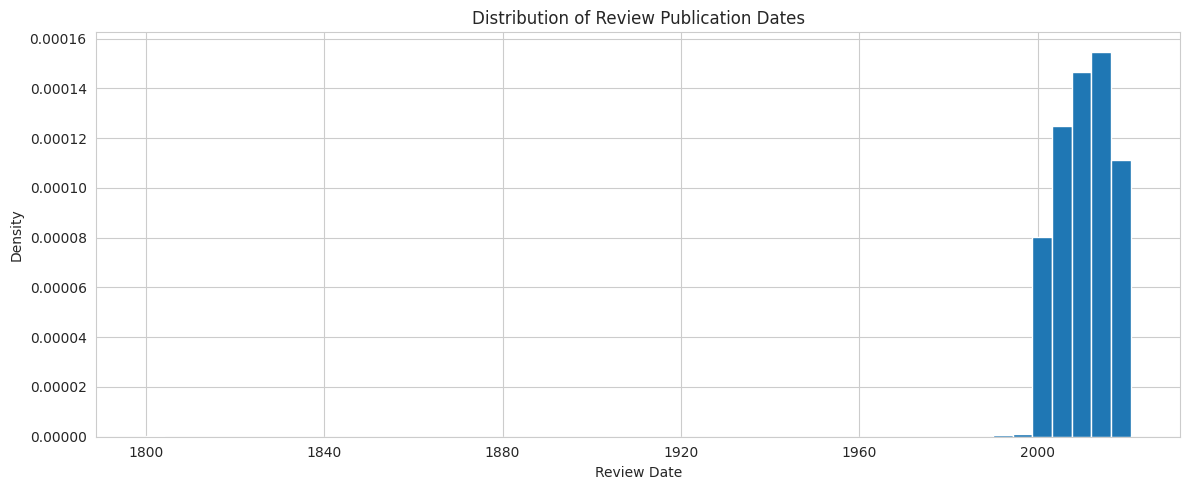

In [15]:
df['review_date'] = pd.to_datetime(df['review_date'])

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.hist(
    df['review_date'],
    bins=50,
    density=True
)

plt.xlabel("Review Date")
plt.ylabel("Density")
plt.title("Distribution of Review Publication Dates")

plt.tight_layout()
plt.show()


In [16]:
# Analiza jakości tekstów recenzji
print("\nAnaliza tekstu")

sample_reviews = df['review_content'].dropna().head(10)
print(f"   Przykład (pierwsze 200 znaków): {sample_reviews.iloc[0][:200]}")

html_pattern = re.compile('<.*?>')
has_html = df['review_content'].str.contains(html_pattern, na=False).sum()
print(f"   Recenzje z HTML: {has_html}")

url_pattern = re.compile(r'https?://\\S+|www\\.\\S+')
has_urls = df['review_content'].str.contains(url_pattern, na=False).sum()
print(f"   Recenzje z URL: {has_urls}")

df['review_length_raw'] = df['review_content'].str.len()
print(f"\n   Statystyki długości:")
print(f"      Średnia: {df['review_length_raw'].mean():.0f}")
print(f"      Mediana: {df['review_length_raw'].median():.0f}")
print(f"      Min-Max: {df['review_length_raw'].min():.0f} - {df['review_length_raw'].max():.0f}")


Analiza tekstu
   Przykład (pierwsze 200 znaków): What's really lacking in The Lightning Thief is a genuine sense of wonder, the same thing that brings viewers back to Hogwarts over and over again.
   Recenzje z HTML: 0
   Recenzje z URL: 0

   Statystyki długości:
      Średnia: 129
      Mediana: 128
      Min-Max: 4 - 257


In [17]:
#Czyszczenie tekstu
print("Czyszczenie tekstu")

CHAT_WORDS = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

def remove_urls(text):
    if not isinstance(text, str):
        return ''
    return re.sub(r'https?://\S+|www\.\S+', '', text)

def remove_emoji(text):
    if not isinstance(text, str):
        return ''
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emotikony
        u"\U0001F300-\U0001F5FF"  # symbole i piktogramy
        u"\U0001F680-\U0001F6FF"  # transport i symbole map
        u"\U0001F1E0-\U0001F1FF"  # flagi (iOS)
        u"\U00002500-\U00002BEF"  # chińskie znaki/symbole
        u"\U00002702-\U000027B0"  # dingbats
        u"\U000024C2-\U0001F251"
        u"\U0001F926-\U0001F937"  # dodatkowe twarze i gesty
        u"\U00010000-\U0010ffff"  # dodatkowe symbole
        u"\U0001F900-\U0001F9FF"  # symbole emotikony (2017+)
        u"\U0001FA00-\U0001FA6F"  # symbole rozszerzone-A
        u"\U0001FA70-\U0001FAFF"  # symbole rozszerzone-B
        u"\u2640-\u2642"           # symbole płci
        u"\u2600-\u2B55"           # różne symbole
        u"\u200d"                  # zero width joiner
        u"\ufe0f"                  # variation selector
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub('', text)


def expand_chat_words(text):
    if not isinstance(text, str):
        return ''
    words = text.split()
    expanded = [CHAT_WORDS.get(word.upper(), word) for word in words]
    return ' '.join(expanded)

def remove_punctuation(text):
    if not isinstance(text, str):
        return ''
    return text.translate(str.maketrans('', '', string.punctuation))

def clean_text_rt(text):
    if not isinstance(text, str) or not text.strip():
        return ''

    text = remove_html_tags(text)
    text = remove_urls(text)
    text = remove_emoji(text)
    text = expand_chat_words(text)
    text = text.lower()
    text = remove_punctuation(text)
    text = remove_extra_spaces(text)

    return text

print("Czyszczenie tekstu w recenzjach...")
df['text_cleaned'] = df['review_content'].apply(clean_text_rt)

print(f"Wyczyszczono {len(df)} recenzji")

Czyszczenie tekstu
Czyszczenie tekstu w recenzjach...
Wyczyszczono 288536 recenzji


In [18]:
# EDA 3: Analiza po czyszczeniu
print("Analiza po czyszczeniu")

df['text_length_cleaned'] = df['text_cleaned'].str.len()
print("Analiza długości tekstów:")
print(df['text_length_cleaned'].describe())

print("\nPrzykładowa recenzja:")
print(df['text_cleaned'].iloc[0][:200])

Analiza po czyszczeniu
Analiza długości tekstów:
count    288536.000000
mean        121.980980
std          57.411691
min           0.000000
25%          80.000000
50%         122.000000
75%         164.000000
max         275.000000
Name: text_length_cleaned, dtype: float64

Przykładowa recenzja:
whats really lacking in the lightning thief is a genuine sense of wonder the same thing that brings viewers back to hogwarts over and over again


In [19]:
#Tokenizacja i lematyzacja
print("\nTokenizacja i lematyzacja")

def get_wordnet_pos(treebank_tag):
    tag_dict = {
        'J': wordnet.ADJ,
        'V': wordnet.VERB,
        'N': wordnet.NOUN,
        'R': wordnet.ADV
    }
    return tag_dict.get(treebank_tag[0], wordnet.NOUN)

def tokenize_and_lemmatize(text, remove_stopwords=True, min_word_length=2):
    if not isinstance(text, str) or not text.strip():
        return []

    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha() and len(word) >= min_word_length]

    if remove_stopwords:
        stop_words_set = set(stopwords.words('english'))
        custom_stopwords = {'film', 'movie', 'movies', 'films', 'scene', 'scenes'}
        stop_words_set.update(custom_stopwords)
        tokens = [word for word in tokens if word not in stop_words_set]

    lemmatizer = WordNetLemmatizer()
    pos_tags = pos_tag(tokens)
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(pos))
                  for word, pos in pos_tags]

    return lemmatized

df['tokens'] = df['text_cleaned'].apply(tokenize_and_lemmatize)
df['token_count'] = df['tokens'].apply(len)
df['tokens_text'] = df['tokens'].apply(lambda x: ' '.join(x))

print(f"   Średnia tokenów: {df['token_count'].mean():.1f}")
print(f"   Mediana: {df['token_count'].median():.0f}")


Tokenizacja i lematyzacja
   Średnia tokenów: 11.5
   Mediana: 11


In [20]:
# Przetwarzanie dat
print("\nPrzetwarzanie dat")

df['review_date'] = pd.to_datetime(df['review_date'], errors='coerce')
df['original_release_date'] = pd.to_datetime(df['original_release_date'], errors='coerce')

df['review_year'] = df['review_date'].dt.year
df['review_month'] = df['review_date'].dt.month
df['release_year'] = df['original_release_date'].dt.year

df['days_since_release'] = (df['review_date'] - df['original_release_date']).dt.days

print(f"   Recenzje z datami: {df['days_since_release'].notna().sum()}")
print(f"   Zakres: {df['review_date'].min()} - {df['review_date'].max()}")



Przetwarzanie dat
   Recenzje z datami: 283202
   Zakres: 1800-01-01 00:00:00 - 2020-10-27 00:00:00


In [21]:
# Analiza czasowa recenzji
print("\nAnaliza czasowa recenzji")

early_reviews = (df['days_since_release'] < 7).sum()
print(f"   Wczesne recenzje (< 7 dni): {early_reviews} ({early_reviews/len(df)*100:.1f}%)")

print(f"\n   Dni od premiery:")
print(f"      Średnia: {df['days_since_release'].mean():.0f}")
print(f"      Mediana: {df['days_since_release'].median():.0f}")
print(f"      Min-Max: {df['days_since_release'].min():.0f} - {df['days_since_release'].max():.0f}")



Analiza czasowa recenzji
   Wczesne recenzje (< 7 dni): 178789 (62.0%)

   Dni od premiery:
      Średnia: 1076
      Mediana: 0
      Min-Max: -77261 - 38854


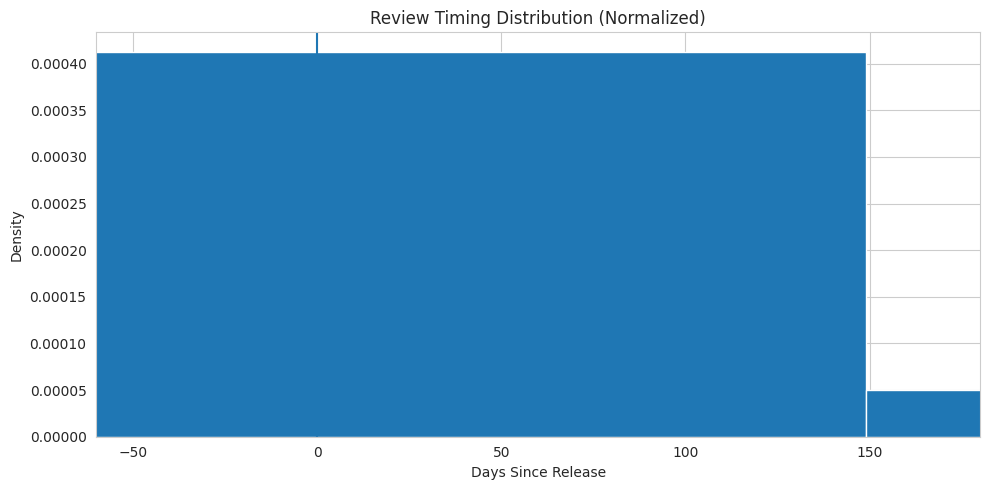

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

df['days_since_release'].plot.hist(
    bins=60,
    density=True
)

plt.axvline(0)
plt.xlabel("Days Since Release")
plt.ylabel("Density")
plt.title("Review Timing Distribution (Normalized)")

plt.xlim(-60, 180)
plt.tight_layout()
plt.show()


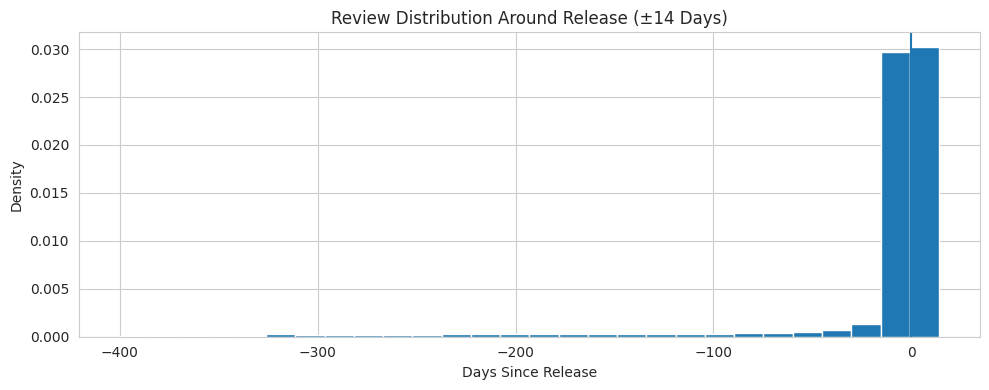

In [23]:
plt.figure(figsize=(10, 4))

df[
    (df['days_since_release'] >= -400) &
    (df['days_since_release'] <= 14)
]['days_since_release'].plot.hist(
    bins=28,
    density=True
)

plt.axvline(0)
plt.xlabel("Days Since Release")
plt.ylabel("Density")
plt.title("Review Distribution Around Release (±14 Days)")

plt.tight_layout()
plt.show()


In [24]:
df.sort_values('days_since_release').head(5)[
    ['movie_title', 'days_since_release', 'review_date', 'original_release_date']
]


,movie_title,days_since_release,review_date,original_release_date
102388,Gunless,-77261.0,1800-01-01,2011-07-15
48037,Black Death,-77135.0,1800-01-01,2011-03-11
105544,Heartless,-77023.0,1800-01-01,2010-11-19
276591,Wah Do Dem,-76869.0,1800-01-01,2010-06-18
276590,Wah Do Dem,-76869.0,1800-01-01,2010-06-18


In [25]:
# upewnij się, że daty są datetime
df['review_date'] = pd.to_datetime(df['review_date'])
df['original_release_date'] = pd.to_datetime(df['original_release_date'])

# znajdź najnowszy film (max release_date)
latest_release_date = df['original_release_date'].max()

# wszystkie recenzje tego filmu
latest_movie_reviews = df[df['original_release_date'] == latest_release_date]

# najstarsza recenzja dla tego filmu
oldest_review_latest_movie = latest_movie_reviews.sort_values('review_date').head(1)

oldest_review_latest_movie[
    ['movie_title', 'original_release_date', 'review_date', 'days_since_release']
]


,movie_title,original_release_date,review_date,days_since_release
17133,Billy the Kid,2020-09-30,2007-12-03,-4685.0


In [26]:
# Feature engineering
print("\nFeature engineering")

df['review_type_encoded'] = df['review_type'].map({'Fresh': 1, 'Rotten': 0})

df['word_count'] = df['text_cleaned'].str.split().str.len()
df['sentence_count'] = df['text_cleaned'].str.count(r'[.!?]') + 1
df['avg_word_length'] = df['text_length_cleaned'] / df['word_count'].replace(0, 1)
df['unique_word_count'] = df['tokens'].apply(lambda x: len(set(x)))
df['lexical_diversity'] = df['unique_word_count'] / df['token_count'].replace(0, 1)

df['is_early_review'] = df['days_since_release'] < 7

print(f"   Utworzono cechy: tekstowe (7), czasowe (5), kategoryczne (1)")


Feature engineering
   Utworzono cechy: tekstowe (7), czasowe (5), kategoryczne (1)


In [30]:
#Dodanie sentymentu z modelu nr.1
print("\nPredykcja sentymentu")

df['predicted_sentiment'] = df['text_cleaned'].apply(predict_sentiment)

sentiment_dist = df['predicted_sentiment'].value_counts()
print(f"   Pozytywny (1): {sentiment_dist.get(1, 0)} ({sentiment_dist.get(1, 0)/len(df)*100:.1f}%)")
print(f"   Negatywny (-1): {sentiment_dist.get(-1, 0)} ({sentiment_dist.get(-1, 0)/len(df)*100:.1f}%)")



Predykcja sentymentu
   Pozytywny (1): 191856 (66.5%)
   Negatywny (-1): 96680 (33.5%)


In [31]:
# EDA 5: Walidacja modelu sentymentu
print("\nWalidacja modelu sentymentu")

crosstab = pd.crosstab(
    df['review_type'],
    df['predicted_sentiment'],
    normalize='index'
) * 100

print(f"\n   Predykcja sentymentu wg typu recenzji (%):")
print(crosstab.round(1).to_string(index=True).replace('\n', '\n   '))

df['sentiment_matches'] = (
    ((df['review_type'] == 'Fresh') & (df['predicted_sentiment'] == 1)) |
    ((df['review_type'] == 'Rotten') & (df['predicted_sentiment'] == -1))
)
agreement = df['sentiment_matches'].mean() * 100
print(f"\n   Zgodność: {agreement:.1f}%")



Walidacja modelu sentymentu

   Predykcja sentymentu wg typu recenzji (%):
predicted_sentiment    -1     1
   review_type                    
   Fresh                12.4  87.6
   Rotten               64.0  36.0

   Zgodność: 77.9%



Generowanie chmur słów


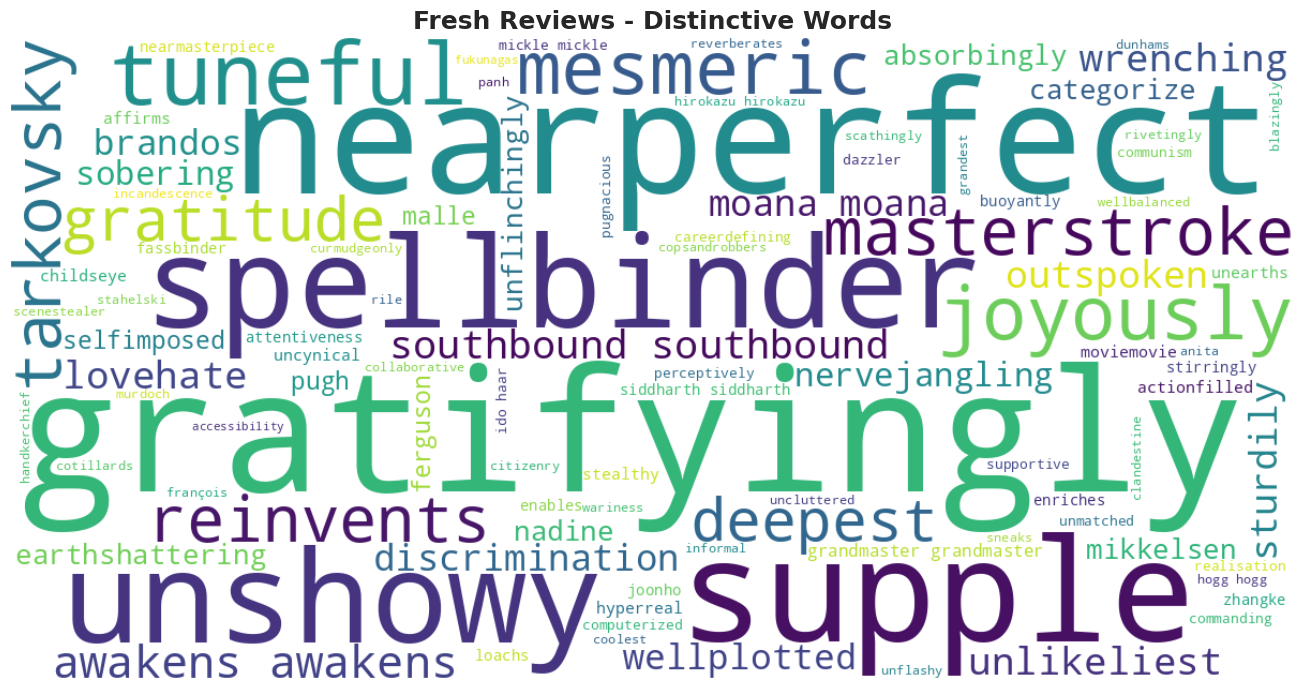

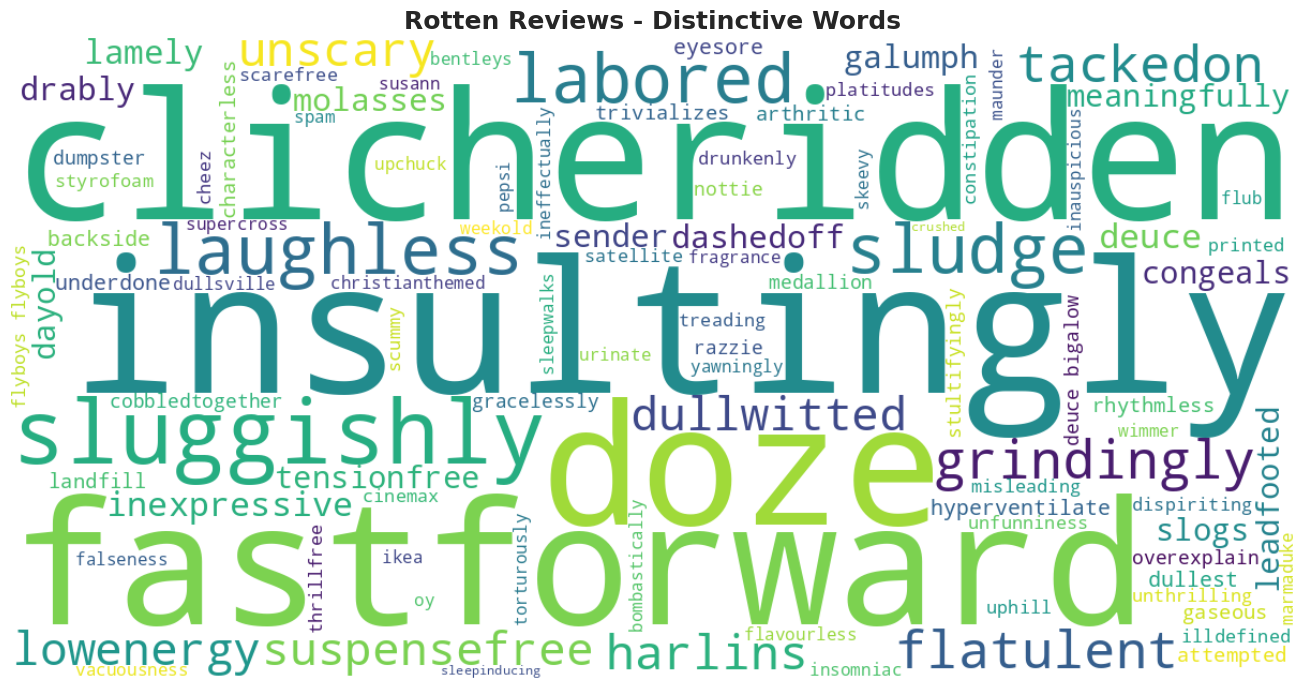

In [32]:
# Generowanie chmur słów
print("\nGenerowanie chmur słów")

def generate_wordcloud(tokens_series, title, exclude_tokens=None):
    all_tokens = [token for tokens in tokens_series for token in tokens]
    if not all_tokens:
        return

    if exclude_tokens:
        all_tokens = [token for token in all_tokens if token not in exclude_tokens]

    if not all_tokens:
        return

    text = ' '.join(all_tokens)
    wordcloud = WordCloud(
        width=1200, height=600,
        background_color='white',
        max_words=100,
        colormap='viridis'
    ).generate(text)

    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=18, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

fresh_reviews = df[df['review_type'] == 'Fresh']
rotten_reviews = df[df['review_type'] == 'Rotten']

fresh_tokens = [token for tokens in fresh_reviews['tokens'] for token in tokens]
rotten_tokens = [token for tokens in rotten_reviews['tokens'] for token in tokens]

fresh_freq = pd.Series(fresh_tokens).value_counts()
rotten_freq = pd.Series(rotten_tokens).value_counts()

common_words = set(fresh_freq.index) & set(rotten_freq.index)

generate_wordcloud(fresh_reviews['tokens'], 'Fresh Reviews - Distinctive Words', exclude_tokens=common_words)
generate_wordcloud(rotten_reviews['tokens'], 'Rotten Reviews - Distinctive Words', exclude_tokens=common_words)

In [33]:
mismatched_df = df[~df['sentiment_matches']]

print(f"Liczba niezgodnych recenzji: {len(mismatched_df)} ({len(mismatched_df)/len(df)*100:.1f}%)")

mismatched_df[['review_type', 'predicted_sentiment', 'text_cleaned']].sample(10)


Liczba niezgodnych recenzji: 63638 (22.1%)


,review_type,predicted_sentiment,text_cleaned
108567,Rotten,1,holy motors is aggressively wild a puzzle that...
48445,Rotten,1,slickly made but not deeply felt and while dir...
70940,Rotten,1,with his stirring visual sense very much intac...
232467,Fresh,-1,the emphasis is on deepfocus 3d spectacle not ...
54032,Rotten,1,what was once an impurely pure outpost of grah...
106772,Rotten,1,
17776,Rotten,1,what kind of international revolutionary whine...
61541,Rotten,1,this highly stylized often beautiful ruminatio...
218733,Rotten,1,could have been hilariously subversive if dire...
232852,Rotten,1,morris tells us nothing about the prurience an...


#LISTA ZMIAN PRZED NAUCZANIEM REGRESJI:

- potencjalnie usunąć absurdalne przypadki pokroju "recenzja napisana w roku 1800", bo mogą psuć działanie modelu nr.3

#MODEL PREDYKCJI OCENY RECENZJI WSPOMAGANY SENTYMENTEM Z MODELU NR.1


Parsowanie ocen do skali 1-10
   Oryginalne oceny: 186017
   Sparsowane: 186017 (100.0%)

   Rozkład ocen (1-10):
      Średnia: 6.5
      Mediana: 7


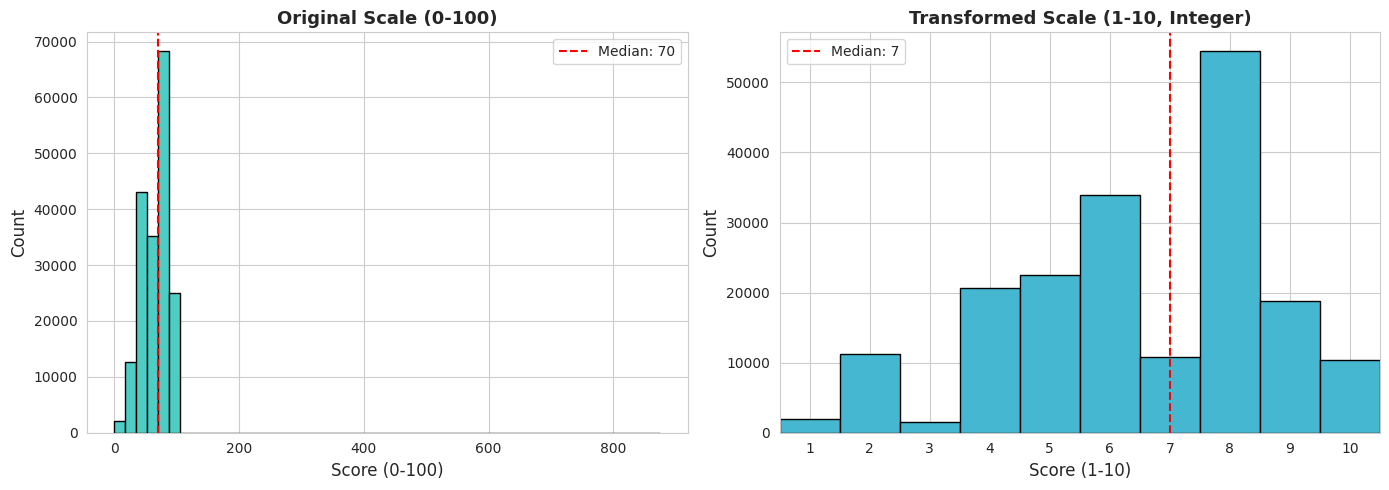

In [34]:
# Parsowanie ocen do skali 0-100, a następnie na 1-10 (pierwsza skala służy do wizualizacji)
print("\nParsowanie ocen do skali 1-10")

GRADE_MAP = {
    "A+": 100, "A": 95, "A-": 90,
    "B+": 87,  "B": 83, "B-": 80,
    "C+": 77,  "C": 73, "C-": 70,
    "D+": 67,  "D": 63, "D-": 60,
    "F": 50
}

def score_to_0_100(x):
    if pd.isna(x):
        return np.nan

    s = str(x).strip()

    m = re.match(r"^(\d+(?:\.\d+)?)\s*%$", s)
    if m:
        return float(m.group(1))

    m = re.match(r"^(\d+(?:\.\d+)?)\s*/\s*(\d+(?:\.\d+)?)$", s)
    if m:
        num, den = float(m.group(1)), float(m.group(2))
        if den > 0:
            return 100.0 * num / den

    m = re.match(r"^(\d+(?:\.\d+)?)$", s)
    if m:
        num = float(m.group(1))
        if num <= 5:
            return 100.0 * num / 5.0
        elif num <= 10:
            return num * 10.0
        elif num <= 100:
            return num

    if s.upper().strip() in GRADE_MAP:
        return float(GRADE_MAP[s.upper().strip()])

    return np.nan

df["score_100"] = df["review_score"].apply(score_to_0_100)
df["score_10"] = (df["score_100"] / 10.0).round().clip(1, 10).astype('Int64')

original_count = df["review_score"].notna().sum()
parsed_count = df["score_10"].notna().sum()
success_rate = (parsed_count / original_count * 100) if original_count > 0 else 0

print(f"   Oryginalne oceny: {original_count}")
print(f"   Sparsowane: {parsed_count} ({success_rate:.1f}%)")
print(f"\n   Rozkład ocen (1-10):")
print(f"      Średnia: {df['score_10'].mean():.1f}")
print(f"      Mediana: {df['score_10'].median():.0f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df["score_100"].dropna().hist(bins=50, ax=axes[0], edgecolor='black', color='#4ECDC4')
axes[0].set_xlabel("Score (0-100)", fontsize=12)
axes[0].set_ylabel("Count", fontsize=12)
axes[0].set_title("Original Scale (0-100)", fontsize=13, fontweight='bold')
axes[0].axvline(df["score_100"].median(), color='red', linestyle='--',
                label=f'Median: {df["score_100"].median():.0f}')
axes[0].legend()

df["score_10"].dropna().hist(bins=10, range=(0.5, 10.5), ax=axes[1],
                              edgecolor='black', color='#45B7D1', align='mid')
axes[1].set_xlabel("Score (1-10)", fontsize=12)
axes[1].set_ylabel("Count", fontsize=12)
axes[1].set_title("Transformed Scale (1-10, Integer)", fontsize=13, fontweight='bold')
axes[1].axvline(df["score_10"].median(), color='red', linestyle='--',
                label=f'Median: {df["score_10"].median():.0f}')
axes[1].legend()
axes[1].set_xticks(range(1, 11))
axes[1].set_xlim(0.5, 10.5)

plt.tight_layout()
plt.show()



Analiza n-gramów i log-odds
   Analizowanych recenzji: 178134
   Zakres ocen: 1 - 10

   TOP 30 n-gramów zwiększających ocenę:
       ngram  log_odds
    never loses  5.469646
    masterpiece  4.675679
   never boring  4.203990
      marvelous  4.146635
       not only  4.099256
      cant wait  3.854571
      kill bill  3.839581
        sublime  3.834011
      afraid to  3.787756
      even when  3.713804
      be missed  3.693606
        perfect  3.630643
     perfection  3.600759
        hell of  3.582603
        no less  3.559120
    ratatouille  3.555770
      wonderful  3.548142
       the void  3.526429
    masterfully  3.517278
    brilliantly  3.505846
     unmissable  3.495969
   exhilarating  3.493156
     quite like  3.471403
    oscarworthy  3.454316
       at worst  3.439306
   blade runner  3.424263
    even better  3.420687
   electrifying  3.417888
      brilliant  3.413971
         leighs  3.398806

   TOP 30 n-gramów obniżających ocenę:
         ngram  log_odds
    

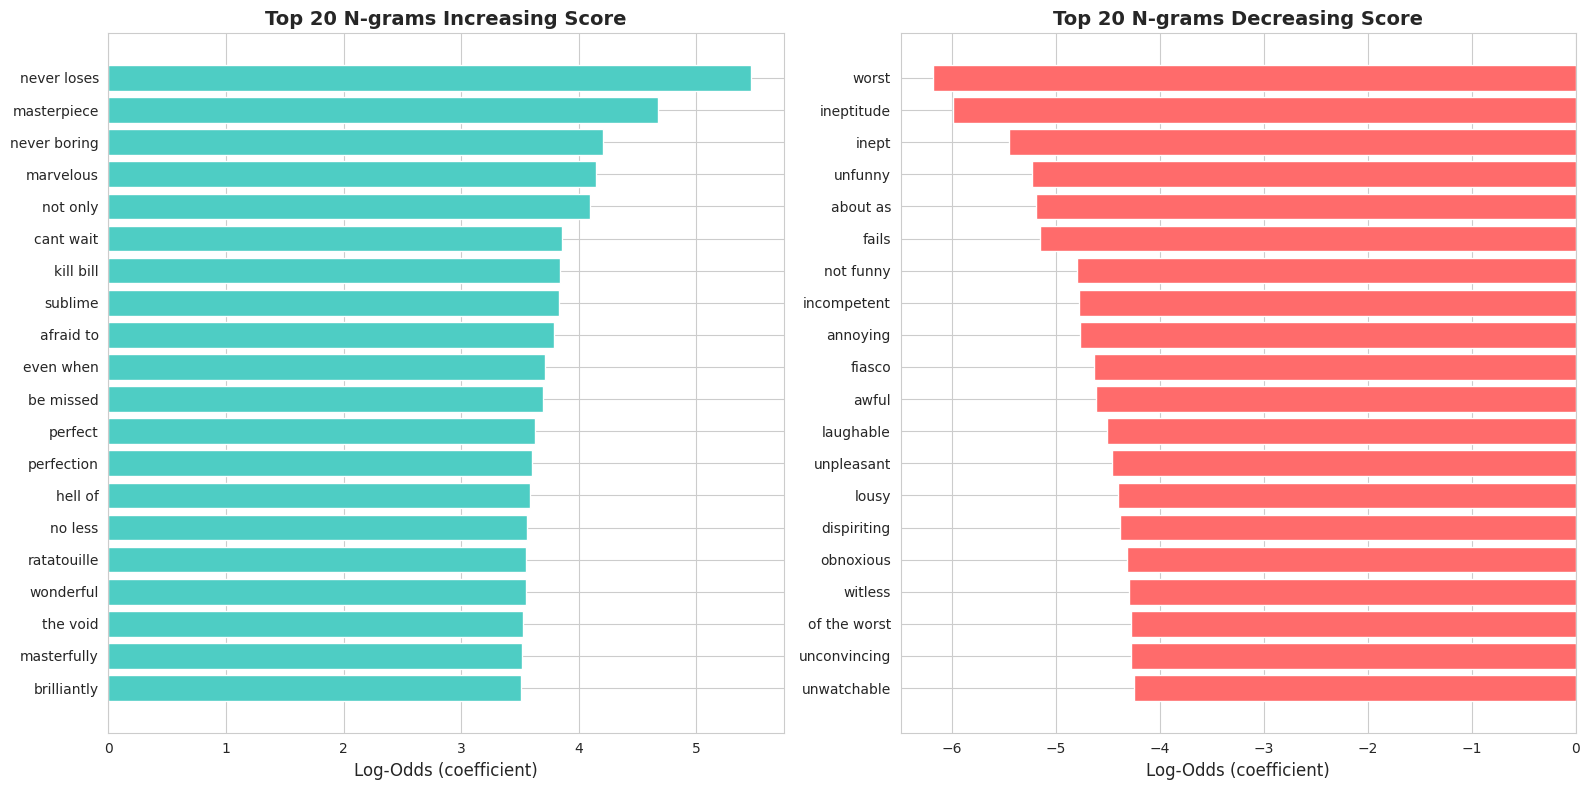


   Łączna liczba cech: 20000


In [37]:
# Analiza n-gramów i log-odds
print("\nAnaliza n-gramów i log-odds")

df_for_ngrams = df[
    df["score_10"].notna() &
    (df["text_cleaned"].str.strip() != "")
].copy()

print(f"   Analizowanych recenzji: {len(df_for_ngrams)}")
print(f"   Zakres ocen: {df_for_ngrams['score_10'].min():.0f} - {df_for_ngrams['score_10'].max():.0f}")

vectorizer_ngrams = TfidfVectorizer(
    ngram_range=(1, 3), #Używane są uni-gramy, bi-gramy oraz tri-gramy
    min_df=10,
    max_features=20000,
    sublinear_tf=True
)

X_ngrams = vectorizer_ngrams.fit_transform(df_for_ngrams["text_cleaned"])
y_ngrams = df_for_ngrams["score_10"].astype(float)

ridge_ngrams = Ridge(alpha=1.0)
ridge_ngrams.fit(X_ngrams, y_ngrams)

feature_names = vectorizer_ngrams.get_feature_names_out()
coefficients = ridge_ngrams.coef_

ngram_weights = pd.DataFrame({
    'ngram': feature_names,
    'log_odds': coefficients
})

ngram_weights = ngram_weights.sort_values('log_odds', ascending=False)

print("\n   TOP 30 n-gramów zwiększających ocenę:")
print(ngram_weights.head(30).to_string(index=False).replace('\n', '\n   '))

print("\n   TOP 30 n-gramów obniżających ocenę:")
print(ngram_weights.tail(30).to_string(index=False).replace('\n', '\n   '))

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

top_positive = ngram_weights.head(20)
axes[0].barh(top_positive['ngram'], top_positive['log_odds'], color='#4ECDC4')
axes[0].set_xlabel('Log-Odds (coefficient)', fontsize=12)
axes[0].set_title('Top 20 N-grams Increasing Score', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

top_negative = ngram_weights.tail(20).sort_values('log_odds')
axes[1].barh(top_negative['ngram'], top_negative['log_odds'], color='#FF6B6B')
axes[1].set_xlabel('Log-Odds (coefficient)', fontsize=12)
axes[1].set_title('Top 20 N-grams Decreasing Score', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print(f"\n   Łączna liczba cech: {len(feature_names)}")



Trening modelu regresji: tekst → ocena (1-10)
   Dataset: 178134 recenzji
   Zakres ocen: 1.0 - 10.0
   Train: 142507 | Test: 35627

   Train MAE: 1.175
   Test MAE:  1.372
   Test RMSE: 1.734
   Test R²:   0.351

   Tolerancja predykcji:
      ±0.5 punktu: 25.3%
      ±1.0 punktu: 46.5%
      ±1.5 punktu: 63.9%


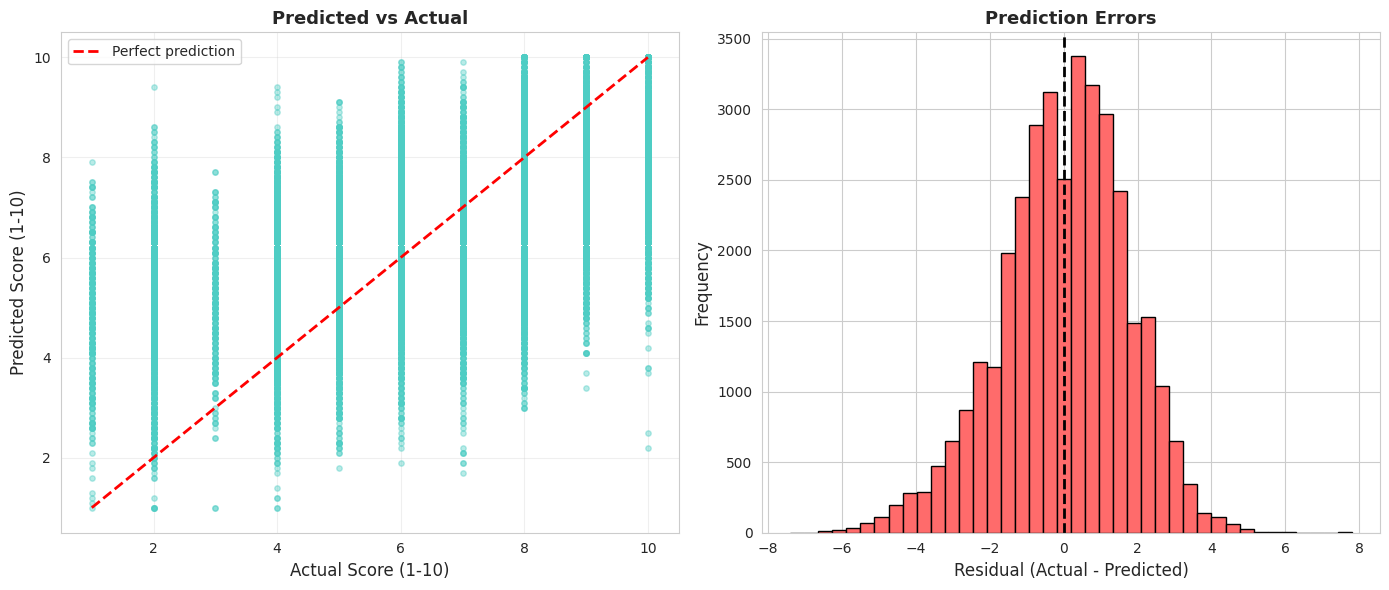

In [41]:
# Trening modelu regresji: tekst → ocena (1-10)
print("\nTrening modelu regresji: tekst → ocena (1-10)")

df_with_score = df[
    df["score_10"].notna() &
    (df["text_cleaned"].str.strip() != "")
].copy()

print(f"   Dataset: {len(df_with_score)} recenzji")
print(f"   Zakres ocen: {df_with_score['score_10'].min():.1f} - {df_with_score['score_10'].max():.1f}")

X = df_with_score["text_cleaned"]
y = df_with_score["score_10"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"   Train: {len(X_train)} | Test: {len(X_test)}")

regressor = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_features=30000)),
    ("ridge", Ridge(alpha=1.0))
])

regressor.fit(X_train, y_train)

pred_train = regressor.predict(X_train).clip(1, 10).round(1)
pred_test = regressor.predict(X_test).clip(1, 10).round(1)

mae_train = mean_absolute_error(y_train, pred_train)
mae_test = mean_absolute_error(y_test, pred_test)
rmse_test = mean_squared_error(y_test, pred_test) ** 0.5
r2_test = r2_score(y_test, pred_test)

print(f"\n   Train MAE: {mae_train:.3f}")
print(f"   Test MAE:  {mae_test:.3f}")
print(f"   Test RMSE: {rmse_test:.3f}")
print(f"   Test R²:   {r2_test:.3f}")

# Tolerancja predykcji
within_05 = (np.abs(y_test - pred_test) <= 0.5).mean()
within_10 = (np.abs(y_test - pred_test) <= 1.0).mean()
within_15 = (np.abs(y_test - pred_test) <= 1.5).mean()

print(f"\n   Tolerancja predykcji:")
print(f"      ±0.5 punktu: {within_05:.1%}")
print(f"      ±1.0 punktu: {within_10:.1%}")
print(f"      ±1.5 punktu: {within_15:.1%}")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(y_test, pred_test, alpha=0.4, s=15, color='#4ECDC4')
axes[0].plot([1, 10], [1, 10], 'r--', lw=2, label='Perfect prediction')
axes[0].set_xlabel("Actual Score (1-10)", fontsize=12)
axes[0].set_ylabel("Predicted Score (1-10)", fontsize=12)
axes[0].set_title("Predicted vs Actual", fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].set_xlim(0.5, 10.5)
axes[0].set_ylim(0.5, 10.5)

residuals = y_test - pred_test
axes[1].hist(residuals, bins=40, edgecolor='black', color='#FF6B6B')
axes[1].set_xlabel("Residual (Actual - Predicted)", fontsize=12)
axes[1].set_ylabel("Frequency", fontsize=12)
axes[1].set_title("Prediction Errors", fontsize=13, fontweight='bold')
axes[1].axvline(0, color='black', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()

In [42]:
# Predykcja dla całego datasetu
print("\nPredykcja dla całego datasetu")

df["predicted_score_10"] = np.nan
mask = df["text_cleaned"].notna() & (df["text_cleaned"].str.strip() != "")

df.loc[mask, "predicted_score_10"] = (
    regressor.predict(df.loc[mask, "text_cleaned"])
    .clip(1, 10)
    .round(1)
)

print(f"   Predykcje dla {mask.sum()} recenzji")
print(f"\n   Rozkład predykcji:")
print(f"      Średnia: {df['predicted_score_10'].mean():.2f}")
print(f"      Mediana: {df['predicted_score_10'].median():.1f}")
print(f"      Min-Max: {df['predicted_score_10'].min():.1f} - {df['predicted_score_10'].max():.1f}")

df["score_residual"] = df["score_10"] - df["predicted_score_10"]

print(f"\n   Błąd predykcji (residuals):")
print(f"      Średnia: {df['score_residual'].mean():.3f}")
print(f"      Mediana: {df['score_residual'].median():.3f}")
print(f"      Odch. std: {df['score_residual'].std():.3f}")


Predykcja dla całego datasetu
   Predykcje dla 280632 recenzji

   Rozkład predykcji:
      Średnia: 6.52
      Mediana: 6.6
      Min-Max: 1.0 - 10.0

   Błąd predykcji (residuals):
      Średnia: 0.000
      Mediana: 0.100
      Odch. std: 1.538


#LISTA ZMIAN PO PREDYKCJI OCEN

- zastanowić się nad określaniem czy znikoma różnica między ocenami recenzenta to dobra rzecz

In [ ]:
# detekcja większej ilości recenzji w trakcie 24h recenzenta - raczej nie powinien np wystawić 20 recenzji na dzień
from datetime import timedelta
import pandas as pd
import numpy as np

print("\n" + "="*60)
print("CALCULATING REVIEWER BURST DETECTION")
print("="*60)

def calculate_reviewer_burst(group):
    """
    Wykrywa burst activity dla pojedynczego recenzenta.
    Podejrzane: wiele recenzji w krótkim czasie.
    """
    group = group.sort_values('review_date').copy()
    total_reviews = len(group)

    counts_24h = []
    counts_7d = []

    for idx, row in group.iterrows():
        current_time = row['review_date']

        # Okno 24h
        window_24h_start = current_time - timedelta(hours=24)
        count_24h = ((group['review_date'] >= window_24h_start) &
                     (group['review_date'] <= current_time)).sum()
        counts_24h.append(count_24h)

        # Okno 7 dni
        window_7d_start = current_time - timedelta(days=7)
        count_7d = ((group['review_date'] >= window_7d_start) &
                    (group['review_date'] <= current_time)).sum()
        counts_7d.append(count_7d)

    group['reviewer_reviews_last_24h'] = counts_24h
    group['reviewer_reviews_last_7d'] = counts_7d

    # Normalizacja
    group['reviewer_burst_ratio_24h'] = group['reviewer_reviews_last_24h'] / total_reviews

    return group

# Zastosuj per reviewer
print("🔄 Processing burst detection per reviewer...")
df = df.groupby('critic_name', group_keys=False).apply(
    calculate_reviewer_burst
)

# ========================================
# KROK 2: Flagi burst dla recenzentów
# ========================================

# Thresholdy - dostosuj do swoich danych
df['is_reviewer_burst_24h'] = df['reviewer_reviews_last_24h'] > 20  # >20 recenzji w 24h
df['is_reviewer_burst_7d'] = df['reviewer_reviews_last_7d'] > 50     # >50 recenzji w tydzień

# Normalized (np. >30% wszystkich recenzji w 24h)
df['is_reviewer_burst_normalized'] = df['reviewer_burst_ratio_24h'] > 0.3

# Combined
df['is_reviewer_burst_any'] = (
    df['is_reviewer_burst_24h'] |
    df['is_reviewer_burst_7d'] |
    df['is_reviewer_burst_normalized']
)

print(f"\n✅ Reviewer burst detection complete:")
print(f"   Burst 24h (>20 reviews): {df['is_reviewer_burst_24h'].sum()} reviews ({df['is_reviewer_burst_24h'].mean()*100:.1f}%)")
print(f"   Burst 7d (>50 reviews): {df['is_reviewer_burst_7d'].sum()} reviews ({df['is_reviewer_burst_7d'].mean()*100:.1f}%)")
print(f"   Normalized burst (>30% in 24h): {df['is_reviewer_burst_normalized'].sum()} reviews ({df['is_reviewer_burst_normalized'].mean()*100:.1f}%)")
print(f"   Any burst: {df['is_reviewer_burst_any'].sum()} reviews ({df['is_reviewer_burst_any'].mean()*100:.1f}%)")

# ========================================
# KROK 3: Identyfikacja najgorszych recenzentów
# ========================================
print("\n" + "="*60)
print("ANALYZING BURSTY REVIEWERS")
print("="*60)

# Agreguj per reviewer
bursty_reviewers = df[df['is_reviewer_burst_any']].groupby('critic_name').agg({
    'reviewer_reviews_last_24h': 'max',
    'reviewer_reviews_last_7d': 'max',
    'reviewer_burst_ratio_24h': 'max',
    'review_date': ['min', 'max'],
    'review_content': 'count'
}).reset_index()

bursty_reviewers.columns = ['critic_name', 'max_burst_24h', 'max_burst_7d',
                             'max_burst_ratio', 'first_review', 'last_review',
                             'total_reviews']
bursty_reviewers = bursty_reviewers.sort_values('max_burst_24h', ascending=False)

print(f"\n👤 Reviewers with burst activity: {len(bursty_reviewers)}")
print("\n🚨 TOP 20 Most Bursty Reviewers:")
print(bursty_reviewers.head(20).to_string(index=False))

# ========================================
# KROK 4: Wizualizacja konkretnego recenzenta
# ========================================
if len(bursty_reviewers) > 0:
    import matplotlib.pyplot as plt

    example_reviewer = bursty_reviewers.iloc[0]['critic_name']
    reviewer_data = df[df['critic_name'] == example_reviewer].sort_values('review_date')

    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle(f'Burst Analysis: {example_reviewer}', fontsize=16, fontweight='bold')

    # Plot 1: Time series - reviews in last 24h
    reviewer_data.set_index('review_date')['reviewer_reviews_last_24h'].plot(
        ax=axes[0, 0], color='red', linewidth=2
    )
    axes[0, 0].axhline(y=20, color='black', linestyle='--',
                       linewidth=2, label='Burst threshold (20)')
    axes[0, 0].set_title('Reviews Published in Last 24h (Rolling)', fontweight='bold')
    axes[0, 0].set_ylabel('Reviews in last 24h', fontsize=11)
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Time series - reviews in last 7d
    reviewer_data.set_index('review_date')['reviewer_reviews_last_7d'].plot(
        ax=axes[0, 1], color='orange', linewidth=2
    )
    axes[0, 1].axhline(y=50, color='black', linestyle='--',
                       linewidth=2, label='Burst threshold (50)')
    axes[0, 1].set_title('Reviews Published in Last 7 Days (Rolling)', fontweight='bold')
    axes[0, 1].set_ylabel('Reviews in last 7 days', fontsize=11)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Daily distribution
    daily_counts = reviewer_data['review_date'].dt.date.value_counts().sort_index()
    daily_counts.plot(kind='bar', ax=axes[1, 0], color='steelblue', width=0.8)
    axes[1, 0].set_title('Daily Review Count', fontweight='bold')
    axes[1, 0].set_ylabel('Number of Reviews', fontsize=11)
    axes[1, 0].set_xlabel('Date', fontsize=11)
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, alpha=0.3, axis='y')

    # Plot 4: Hourly distribution (if timestamps available)
    if pd.api.types.is_datetime64_any_dtype(reviewer_data['review_date']):
        hourly_counts = reviewer_data['review_date'].dt.hour.value_counts().sort_index()
        hourly_counts.plot(kind='bar', ax=axes[1, 1], color='#4ECDC4', width=0.8)
        axes[1, 1].set_title('Review Distribution by Hour of Day', fontweight='bold')
        axes[1, 1].set_ylabel('Number of Reviews', fontsize=11)
        axes[1, 1].set_xlabel('Hour (0-23)', fontsize=11)
        axes[1, 1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    # Stats dla tego recenzenta
    print(f"\n📊 Burst Analysis for '{example_reviewer}':")
    print(f"   Total reviews: {len(reviewer_data)}")
    print(f"   Peak 24h burst: {reviewer_data['reviewer_reviews_last_24h'].max()} reviews")
    print(f"   Peak 7d burst: {reviewer_data['reviewer_reviews_last_7d'].max()} reviews")
    print(f"   Max burst ratio: {reviewer_data['reviewer_burst_ratio_24h'].max()*100:.1f}%")
    print(f"   Reviews in burst periods: {reviewer_data['is_reviewer_burst_any'].sum()}")
    print(f"   Activity span: {(reviewer_data['review_date'].max() - reviewer_data['review_date'].min()).days} days")

# ========================================
# KROK 5: Porównanie thresholds
# ========================================
print("\n" + "="*60)
print("REVIEWER BURST THRESHOLD COMPARISON")
print("="*60)

thresholds_24h = [5, 10, 15, 20, 30, 50, 100]
thresholds_7d = [20, 30, 50, 75, 100, 150, 200]

print("\n24-hour window thresholds:")
print(f"{'Threshold':<12} {'Reviews':<12} {'% of Reviews':<15} {'Reviewers':<12}")
print("-"*60)

for thresh in thresholds_24h:
    review_count = (df['reviewer_reviews_last_24h'] > thresh).sum()
    review_pct = review_count / len(df) * 100
    reviewer_count = df[df['reviewer_reviews_last_24h'] > thresh]['critic_name'].nunique()

    print(f">{thresh:<11} {review_count:<12} {review_pct:<15.2f}% {reviewer_count:<12}")

print("\n7-day window thresholds:")
print(f"{'Threshold':<12} {'Reviews':<12} {'% of Reviews':<15} {'Reviewers':<12}")
print("-"*60)

for thresh in thresholds_7d:
    review_count = (df['reviewer_reviews_last_7d'] > thresh).sum()
    review_pct = review_count / len(df) * 100
    reviewer_count = df[df['reviewer_reviews_last_7d'] > thresh]['critic_name'].nunique()

    print(f">{thresh:<11} {review_count:<12} {review_pct:<15.2f}% {reviewer_count:<12}")

# ========================================
# KROK 6: Statystyki ogólne
# ========================================
print("\n" + "="*60)
print("REVIEWER BURST STATISTICS")
print("="*60)

print("\n📈 24h burst intensity distribution:")
print(f"   Mean: {df['reviewer_reviews_last_24h'].mean():.2f}")
print(f"   Median: {df['reviewer_reviews_last_24h'].median():.1f}")
print(f"   75th percentile: {df['reviewer_reviews_last_24h'].quantile(0.75):.1f}")
print(f"   95th percentile: {df['reviewer_reviews_last_24h'].quantile(0.95):.1f}")
print(f"   99th percentile: {df['reviewer_reviews_last_24h'].quantile(0.99):.1f}")
print(f"   Max: {df['reviewer_reviews_last_24h'].max():.0f}")

print("\n📈 7-day burst intensity distribution:")
print(f"   Mean: {df['reviewer_reviews_last_7d'].mean():.2f}")
print(f"   Median: {df['reviewer_reviews_last_7d'].median():.1f}")
print(f"   75th percentile: {df['reviewer_reviews_last_7d'].quantile(0.75):.1f}")
print(f"   95th percentile: {df['reviewer_reviews_last_7d'].quantile(0.95):.1f}")
print(f"   99th percentile: {df['reviewer_reviews_last_7d'].quantile(0.99):.1f}")
print(f"   Max: {df['reviewer_reviews_last_7d'].max():.0f}")

# Histogramy
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 24h bursts
df['reviewer_reviews_last_24h'].hist(bins=50, ax=axes[0], color='#FF6B6B', edgecolor='black')
axes[0].axvline(20, color='black', linestyle='--', linewidth=2, label='Threshold: 20')
axes[0].set_xlabel('Reviews by Reviewer in 24h', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Reviewer 24h Burst Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].set_yscale('log')

# 7d bursts
df['reviewer_reviews_last_7d'].hist(bins=50, ax=axes[1], color='#FFA07A', edgecolor='black')
axes[1].axvline(50, color='black', linestyle='--', linewidth=2, label='Threshold: 50')
axes[1].set_xlabel('Reviews by Reviewer in 7 Days', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Reviewer 7-Day Burst Distribution', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()



In [ ]:
#Statystyki recenzentów

# 1. Podstawowe statystyki recenzenta
reviewer_stats = df.groupby('critic_name').agg({
    'review_date': ['count', 'min', 'max'],  # ile recenzji, zakres dat
    'review_type': lambda x: (x == 'Fresh').mean(),  # % pozytywnych
    'movie_title': 'nunique',  # ile różnych filmów
    'score_10': ['mean', 'std'],  # średnia ocena, wariancja
    'text_length_cleaned': 'mean'  # średnia długość tekstu
}).reset_index()

reviewer_stats.columns = ['critic_name', 'review_count', 'first_review',
                          'last_review', 'positive_ratio', 'unique_movies',
                          'avg_score', 'score_std', 'avg_text_length']

# 2. Reviewer deviation (web:12) - jak różni się od średniej
reviewer_stats['deviation_from_mean'] = np.abs(
    reviewer_stats['avg_score'] - df['score_10'].mean()
)

# 3. Activity span
reviewer_stats['days_active'] = (
    reviewer_stats['last_review'] - reviewer_stats['first_review']
).dt.days

# 4. Suspicious patterns
reviewer_stats['is_suspicious'] = (
    (reviewer_stats['review_count'] < 5) |  # mało recenzji
    (reviewer_stats['positive_ratio'] > 0.95) |  # tylko pozytywne
    (reviewer_stats['positive_ratio'] < 0.05) |  # tylko negatywne
    (reviewer_stats['days_active'] < 30)  # krótki okres aktywności
)

# 5. Merge z głównym df
df = df.merge(reviewer_stats, on='critic_name', how='left')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ========================================
# SETUP
# ========================================
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 10)

# ========================================
# VIZ 1: OVERVIEW - Podstawowe metryki recenzentów
# ========================================
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Reviewer Statistics Overview', fontsize=16, fontweight='bold', y=0.995)

# 1.1 Review count distribution
axes[0, 0].hist(reviewer_stats['review_count'], bins=50, color='#4ECDC4', edgecolor='black')
axes[0, 0].axvline(reviewer_stats['review_count'].median(), color='red',
                   linestyle='--', label=f"Median: {reviewer_stats['review_count'].median():.0f}")
axes[0, 0].set_xlabel('Number of Reviews', fontsize=11)
axes[0, 0].set_ylabel('Number of Reviewers', fontsize=11)
axes[0, 0].set_title('Distribution of Review Count per Reviewer', fontweight='bold')
axes[0, 0].set_yscale('log')
axes[0, 0].legend()

# 1.2 Positive ratio distribution
axes[0, 1].hist(reviewer_stats['positive_ratio'], bins=30, color='#45B7D1', edgecolor='black')
axes[0, 1].axvline(0.5, color='green', linestyle='--', label='Balanced (50%)')
axes[0, 1].axvline(0.95, color='red', linestyle='--', label='Suspicious (>95%)')
axes[0, 1].axvline(0.05, color='red', linestyle='--', label='Suspicious (<5%)')
axes[0, 1].set_xlabel('Positive Review Ratio', fontsize=11)
axes[0, 1].set_ylabel('Number of Reviewers', fontsize=11)
axes[0, 1].set_title('Fresh/Rotten Ratio Distribution', fontweight='bold')
axes[0, 1].legend(fontsize=9)

# 1.3 Days active distribution
axes[0, 2].hist(reviewer_stats['days_active'], bins=50, color='#FF6B6B', edgecolor='black')
axes[0, 2].axvline(30, color='red', linestyle='--', label='Suspicious (<30 days)')
axes[0, 2].set_xlabel('Days Active', fontsize=11)
axes[0, 2].set_ylabel('Number of Reviewers', fontsize=11)
axes[0, 2].set_title('Reviewer Activity Span', fontweight='bold')
axes[0, 2].legend()

# 1.4 Average score distribution
axes[1, 0].hist(reviewer_stats['avg_score'].dropna(), bins=30, color='#95E1D3', edgecolor='black')
axes[1, 0].axvline(reviewer_stats['avg_score'].mean(), color='red',
                   linestyle='--', label=f"Mean: {reviewer_stats['avg_score'].mean():.2f}")
axes[1, 0].set_xlabel('Average Score (1-10)', fontsize=11)
axes[1, 0].set_ylabel('Number of Reviewers', fontsize=11)
axes[1, 0].set_title('Average Reviewer Score Distribution', fontweight='bold')
axes[1, 0].legend()

# 1.5 Score standard deviation
axes[1, 1].hist(reviewer_stats['score_std'].dropna(), bins=30, color='#F38181', edgecolor='black')
axes[1, 1].set_xlabel('Score Standard Deviation', fontsize=11)
axes[1, 1].set_ylabel('Number of Reviewers', fontsize=11)
axes[1, 1].set_title('Score Variability per Reviewer', fontweight='bold')

# 1.6 Unique movies reviewed
axes[1, 2].hist(reviewer_stats['unique_movies'], bins=50, color='#AA96DA', edgecolor='black')
axes[1, 2].set_xlabel('Number of Unique Movies', fontsize=11)
axes[1, 2].set_ylabel('Number of Reviewers', fontsize=11)
axes[1, 2].set_title('Movies Reviewed per Critic', fontweight='bold')
axes[1, 2].set_yscale('log')

plt.tight_layout()
plt.show()

# ========================================
# VIZ 2: SUSPICIOUS vs NORMAL Comparison
# ========================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Suspicious vs Normal Reviewers Comparison', fontsize=16, fontweight='bold')

suspicious = reviewer_stats[reviewer_stats['is_suspicious']]
normal = reviewer_stats[~reviewer_stats['is_suspicious']]

print(f"\n📊 Reviewer Classification:")
print(f"   Suspicious reviewers: {len(suspicious)} ({len(suspicious)/len(reviewer_stats)*100:.1f}%)")
print(f"   Normal reviewers: {len(normal)} ({len(normal)/len(reviewer_stats)*100:.1f}%)")

# 2.1 Review count comparison
data_to_plot = [normal['review_count'], suspicious['review_count']]
bp1 = axes[0, 0].boxplot(data_to_plot, labels=['Normal', 'Suspicious'],
                          patch_artist=True, widths=0.6)
bp1['boxes'][0].set_facecolor('#4ECDC4')
bp1['boxes'][1].set_facecolor('#FF6B6B')
axes[0, 0].set_ylabel('Review Count', fontsize=11)
axes[0, 0].set_title('Review Count: Normal vs Suspicious', fontweight='bold')
axes[0, 0].set_yscale('log')

# 2.2 Positive ratio comparison
data_to_plot = [normal['positive_ratio'], suspicious['positive_ratio']]
bp2 = axes[0, 1].boxplot(data_to_plot, labels=['Normal', 'Suspicious'],
                          patch_artist=True, widths=0.6)
bp2['boxes'][0].set_facecolor('#4ECDC4')
bp2['boxes'][1].set_facecolor('#FF6B6B')
axes[0, 1].set_ylabel('Positive Ratio', fontsize=11)
axes[0, 1].set_title('Fresh Ratio: Normal vs Suspicious', fontweight='bold')
axes[0, 1].axhline(0.5, color='green', linestyle='--', alpha=0.5)

# 2.3 Days active comparison
data_to_plot = [normal['days_active'], suspicious['days_active']]
bp3 = axes[1, 0].boxplot(data_to_plot, labels=['Normal', 'Suspicious'],
                          patch_artist=True, widths=0.6)
bp3['boxes'][0].set_facecolor('#4ECDC4')
bp3['boxes'][1].set_facecolor('#FF6B6B')
axes[1, 0].set_ylabel('Days Active', fontsize=11)
axes[1, 0].set_title('Activity Span: Normal vs Suspicious', fontweight='bold')

# 2.4 Score deviation comparison
data_to_plot = [normal['deviation_from_mean'].dropna(), suspicious['deviation_from_mean'].dropna()]
bp4 = axes[1, 1].boxplot(data_to_plot, labels=['Normal', 'Suspicious'],
                          patch_artist=True, widths=0.6)
bp4['boxes'][0].set_facecolor('#4ECDC4')
bp4['boxes'][1].set_facecolor('#FF6B6B')
axes[1, 1].set_ylabel('Score Deviation from Mean', fontsize=11)
axes[1, 1].set_title('Score Deviation: Normal vs Suspicious', fontweight='bold')

plt.tight_layout()
plt.show()

# ========================================
# VIZ 3: SCATTER PLOTS - Relationships
# ========================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Reviewer Behavior Patterns', fontsize=16, fontweight='bold')

# 3.1 Review count vs Positive ratio
axes[0, 0].scatter(normal['review_count'], normal['positive_ratio'],
                   alpha=0.5, s=30, color='#4ECDC4', label='Normal')
axes[0, 0].scatter(suspicious['review_count'], suspicious['positive_ratio'],
                   alpha=0.7, s=50, color='#FF6B6B', marker='x', label='Suspicious')
axes[0, 0].axhline(0.95, color='red', linestyle='--', alpha=0.3)
axes[0, 0].axhline(0.05, color='red', linestyle='--', alpha=0.3)
axes[0, 0].axvline(5, color='red', linestyle='--', alpha=0.3)
axes[0, 0].set_xlabel('Review Count', fontsize=11)
axes[0, 0].set_ylabel('Positive Ratio', fontsize=11)
axes[0, 0].set_title('Review Count vs Sentiment Bias', fontweight='bold')
axes[0, 0].set_xscale('log')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 3.2 Days active vs Review count
axes[0, 1].scatter(normal['days_active'], normal['review_count'],
                   alpha=0.5, s=30, color='#4ECDC4', label='Normal')
axes[0, 1].scatter(suspicious['days_active'], suspicious['review_count'],
                   alpha=0.7, s=50, color='#FF6B6B', marker='x', label='Suspicious')
axes[0, 1].axvline(30, color='red', linestyle='--', alpha=0.3, label='30-day threshold')
axes[0, 1].set_xlabel('Days Active', fontsize=11)
axes[0, 1].set_ylabel('Review Count', fontsize=11)
axes[0, 1].set_title('Activity Duration vs Volume', fontweight='bold')
axes[0, 1].set_yscale('log')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3.3 Score std vs avg score
axes[1, 0].scatter(normal['avg_score'], normal['score_std'],
                   alpha=0.5, s=30, color='#4ECDC4', label='Normal')
axes[1, 0].scatter(suspicious['avg_score'], suspicious['score_std'],
                   alpha=0.7, s=50, color='#FF6B6B', marker='x', label='Suspicious')
axes[1, 0].set_xlabel('Average Score', fontsize=11)
axes[1, 0].set_ylabel('Score Standard Deviation', fontsize=11)
axes[1, 0].set_title('Score Consistency Pattern', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 3.4 Review count vs unique movies
axes[1, 1].scatter(normal['unique_movies'], normal['review_count'],
                   alpha=0.5, s=30, color='#4ECDC4', label='Normal')
axes[1, 1].scatter(suspicious['unique_movies'], suspicious['review_count'],
                   alpha=0.7, s=50, color='#FF6B6B', marker='x', label='Suspicious')
# Idealna linia: 1 review = 1 movie
max_val = max(reviewer_stats['unique_movies'].max(), reviewer_stats['review_count'].max())
axes[1, 1].plot([0, max_val], [0, max_val], 'g--', alpha=0.3, label='1:1 ratio')
axes[1, 1].set_xlabel('Unique Movies Reviewed', fontsize=11)
axes[1, 1].set_ylabel('Total Review Count', fontsize=11)
axes[1, 1].set_title('Review Diversity Pattern', fontweight='bold')
axes[1, 1].set_xscale('log')
axes[1, 1].set_yscale('log')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ========================================
# VIZ 4: TOP/BOTTOM Reviewers
# ========================================
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Extreme Reviewers Analysis', fontsize=16, fontweight='bold')

# 4.1 Top 20 most active reviewers
top_active = reviewer_stats.nlargest(20, 'review_count')
axes[0, 0].barh(range(len(top_active)), top_active['review_count'], color='#4ECDC4')
axes[0, 0].set_yticks(range(len(top_active)))
axes[0, 0].set_yticklabels(top_active['critic_name'], fontsize=8)
axes[0, 0].set_xlabel('Review Count', fontsize=11)
axes[0, 0].set_title('Top 20 Most Active Reviewers', fontweight='bold')
axes[0, 0].invert_yaxis()

# 4.2 Most biased positive
most_positive = reviewer_stats[reviewer_stats['review_count'] >= 10].nlargest(20, 'positive_ratio')
axes[0, 1].barh(range(len(most_positive)), most_positive['positive_ratio']*100, color='#00EA6E')
axes[0, 1].set_yticks(range(len(most_positive)))
axes[0, 1].set_yticklabels(most_positive['critic_name'], fontsize=8)
axes[0, 1].set_xlabel('Fresh Review % (min 10 reviews)', fontsize=11)
axes[0, 1].set_title('Top 20 Most Positive Reviewers', fontweight='bold')
axes[0, 1].invert_yaxis()

# 4.3 Most biased negative
most_negative = reviewer_stats[reviewer_stats['review_count'] >= 10].nsmallest(20, 'positive_ratio')
axes[1, 0].barh(range(len(most_negative)), most_negative['positive_ratio']*100, color='#FF3B3F')
axes[1, 0].set_yticks(range(len(most_negative)))
axes[1, 0].set_yticklabels(most_negative['critic_name'], fontsize=8)
axes[1, 0].set_xlabel('Fresh Review % (min 10 reviews)', fontsize=11)
axes[1, 0].set_title('Top 20 Most Negative Reviewers', fontweight='bold')
axes[1, 0].invert_yaxis()

# 4.4 Highest deviation from mean score
top_deviation = reviewer_stats[reviewer_stats['review_count'] >= 10].nlargest(20, 'deviation_from_mean')
axes[1, 1].barh(range(len(top_deviation)), top_deviation['deviation_from_mean'], color='#F38181')
axes[1, 1].set_yticks(range(len(top_deviation)))
axes[1, 1].set_yticklabels(top_deviation['critic_name'], fontsize=8)
axes[1, 1].set_xlabel('Score Deviation from Mean (min 10 reviews)', fontsize=11)
axes[1, 1].set_title('Top 20 Most Extreme Scorers', fontweight='bold')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

# ========================================
# VIZ 5: SUMMARY TABLE
# ========================================
print("\n" + "="*80)
print("REVIEWER STATISTICS SUMMARY")
print("="*80)

summary_data = {
    'Metric': ['Total Reviewers', 'Suspicious Reviewers', 'Avg Reviews per Critic',
               'Median Reviews', 'Avg Positive Ratio', 'Avg Days Active',
               'Avg Unique Movies', 'Avg Score Deviation'],
    'All Reviewers': [
        len(reviewer_stats),
        f"{len(suspicious)} ({len(suspicious)/len(reviewer_stats)*100:.1f}%)",
        f"{reviewer_stats['review_count'].mean():.1f}",
        f"{reviewer_stats['review_count'].median():.0f}",
        f"{reviewer_stats['positive_ratio'].mean()*100:.1f}%",
        f"{reviewer_stats['days_active'].mean():.0f}",
        f"{reviewer_stats['unique_movies'].mean():.1f}",
        f"{reviewer_stats['deviation_from_mean'].mean():.2f}"
    ],
    'Normal': [
        len(normal),
        "-",
        f"{normal['review_count'].mean():.1f}",
        f"{normal['review_count'].median():.0f}",
        f"{normal['positive_ratio'].mean()*100:.1f}%",
        f"{normal['days_active'].mean():.0f}",
        f"{normal['unique_movies'].mean():.1f}",
        f"{normal['deviation_from_mean'].mean():.2f}"
    ],
    'Suspicious': [
        len(suspicious),
        f"{len(suspicious)} (100%)",
        f"{suspicious['review_count'].mean():.1f}",
        f"{suspicious['review_count'].median():.0f}",
        f"{suspicious['positive_ratio'].mean()*100:.1f}%",
        f"{suspicious['days_active'].mean():.0f}",
        f"{suspicious['unique_movies'].mean():.1f}",
        f"{suspicious['deviation_from_mean'].mean():.2f}"
    ]
}

import pandas as pd
summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))


In [ ]:
# ========================================
# SUSPICIOUS SCORE: Kompozytowa metryka podejrzliwości recenzenta
# Skala: 1 (najmniej podejrzany) → 10 (najbardziej podejrzany)
# ========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def calculate_reviewer_suspicious_score(df):
    """
    Oblicza suspicious_score dla każdego recenzenta (1-10)
    """

    # 1. Agreguj statystyki per recenzent
    reviewer_stats = df.groupby('critic_name').agg({
        'critic_name': 'count',                    # review_count
        'review_type_encoded': 'mean',             # positive_ratio
        'score_10': ['mean', 'std'],               # score stats
        'is_reviewer_burst_24h': 'sum',            # burst count
        'days_since_release': 'mean',              # avg timing
    }).reset_index()

    reviewer_stats.columns = ['critic_name', 'review_count', 'positive_ratio',
                               'score_mean', 'score_std', 'burst_count', 'avg_days_since_release']

    # 2. Oblicz sub-scores (każdy w skali 0-1)

    # a) Burst behavior (0-1)
    # Wysoki burst = podejrzane
    burst_score = np.clip(reviewer_stats['burst_count'] / 5, 0, 1)

    # b) Review velocity (0-1)
    # Bardzo dużo recenzji = podejrzane
    velocity_score = np.clip((reviewer_stats['review_count'] - 10) / 100, 0, 1)

    # c) Bias detection (0-1)
    # Skrajne positive_ratio (blisko 0 lub 1) = podejrzane
    bias_score = np.abs(reviewer_stats['positive_ratio'] - 0.5) * 2

    # d) Score consistency (0-1)
    # Bardzo niskie std = podejrzane (bot-like behavior)
    consistency_score = 1 - np.clip(reviewer_stats['score_std'] / 2.5, 0, 1)

    # e) Early review pattern (0-1)
    # Częste bardzo wczesne recenzje = podejrzane
    early_score = np.clip((7 - reviewer_stats['avg_days_since_release']) / 7, 0, 1)
    early_score = np.maximum(early_score, 0)

    # 3. Weighted composite (wagi do dostrojenia)
    weights = {
        'burst': 0.30,       # Najważniejszy sygnał
        'velocity': 0.15,
        'bias': 0.25,        # Drugi najważniejszy
        'consistency': 0.20,
        'early': 0.10
    }

    suspicious_raw = (
        weights['burst'] * burst_score +
        weights['velocity'] * velocity_score +
        weights['bias'] * bias_score +
        weights['consistency'] * consistency_score +
        weights['early'] * early_score
    )

    # 4. Skaluj do 1-10
    reviewer_stats['suspicious_score'] = 1 + (suspicious_raw * 9)

    # 5. Merge z powrotem do df
    df = df.merge(
        reviewer_stats[['critic_name', 'suspicious_score']],
        on='critic_name',
        how='left'
    )

    return df, reviewer_stats  # ZWRACAMY OBA


# Użycie - ODBIERAMY OBA
df, reviewer_stats = calculate_reviewer_suspicious_score(df)


In [ ]:
# ========================================
# WIZUALIZACJA: Histogram + Top 20
# ========================================

print("=" * 60)
print("SUSPICIOUS SCORE ANALYSIS")
print("=" * 60)

# Statystyki
print(f"\n📊 Suspicious Score Statistics:")
print(reviewer_stats['suspicious_score'].describe())
print(f"\nTotal reviewers: {len(reviewer_stats)}")
print(f"Highly suspicious (score > 7): {(reviewer_stats['suspicious_score'] > 7).sum()} ({(reviewer_stats['suspicious_score'] > 7).sum()/len(reviewer_stats)*100:.1f}%)")

# Wizualizacja
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Histogram
axes[0].hist(reviewer_stats['suspicious_score'], bins=30, edgecolor='black',
            color='#FF6B6B', alpha=0.7)
axes[0].axvline(reviewer_stats['suspicious_score'].median(),
               color='blue', linestyle='--', linewidth=2,
               label=f"Median: {reviewer_stats['suspicious_score'].median():.2f}")
axes[0].axvline(reviewer_stats['suspicious_score'].mean(),
               color='green', linestyle='--', linewidth=2,
               label=f"Mean: {reviewer_stats['suspicious_score'].mean():.2f}")
axes[0].set_xlabel('Suspicious Score (1-10)', fontsize=12)
axes[0].set_ylabel('Number of Reviewers', fontsize=12)
axes[0].set_title('Distribution of Reviewer Suspicious Scores',
                 fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].set_xlim(0, 11)

# 2. Top 20 bar chart
top_20_suspicious = reviewer_stats.nlargest(20, 'suspicious_score')
axes[1].barh(range(20), top_20_suspicious['suspicious_score'].values,
            color='#FF3B3F', edgecolor='black')
axes[1].set_yticks(range(20))
axes[1].set_yticklabels(top_20_suspicious['critic_name'].values, fontsize=9)
axes[1].set_xlabel('Suspicious Score', fontsize=12)
axes[1].set_title('Top 20 Most Suspicious Critics',
                 fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)
axes[1].axvline(7, color='orange', linestyle='--', linewidth=1.5,
               alpha=0.7, label='High suspicion threshold')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n✅ Suspicious score calculation complete!")


#ZMIANY DO RECENZENTÓW

- usunąć burst 24h, zamienić cechę czasową w modelu nr.3 na burst 7-dniowy - 50 recenzji na tydzień to i tak podejrzanie sporo w realnych warunkach, a daje lepszy pogląd

In [ ]:
import numpy as np
import pandas as pd

# 1) próg "podejrzanego" recenzenta
SUS_TH = 7.0
# alternatywnie: SUS_TH = df['suspicious_score'].quantile(0.995)

# ROZWIĄZANIE: Obsłuż NA przed konwersją na int
df['is_suspicious_reviewer'] = (
    (df['suspicious_score'] >= SUS_TH)
    .fillna(False)  # Zamień NA na False
    .astype(int)
)

movie_susp = (
    df.groupby('movie_title')
      .agg(
          suspicious_reviews=('is_suspicious_reviewer', 'sum'),
          total_reviews=('is_suspicious_reviewer', 'size'),
          suspicious_ratio=('is_suspicious_reviewer', 'mean'),
          suspicious_reviewers=('critic_name', lambda s: s[df.loc[s.index, 'is_suspicious_reviewer'].eq(1)].nunique())
      )
      .reset_index()
)

MIN_TOTAL = 10  # żeby nie pompować filmów z małą liczbą recenzji
movie_susp = movie_susp[movie_susp['total_reviews'] >= MIN_TOTAL].copy()

movie_susp = movie_susp.sort_values(
    ['suspicious_reviews', 'suspicious_ratio', 'total_reviews'],
    ascending=[False, False, False]
)

movie_susp.head(20)


In [ ]:
movie_susp_studio = movie_susp.merge(
    movies_df[['movie_title', 'production_company']].drop_duplicates(),
    on='movie_title',
    how='left'
)

movie_susp_studio.head(20)


In [ ]:
# A) SUMA podejrzanych recenzji per studio
studio_rank = (
    movie_susp_studio
      .groupby('production_company', dropna=False)
      .agg(
          suspicious_reviews=('suspicious_reviews', 'sum'),
          total_reviews=('total_reviews', 'sum'),
          suspicious_ratio=('suspicious_ratio', 'mean'),   # średnia z filmów (nie ważona)
          movies=('movie_title', 'nunique')
      )
      .reset_index()
      .sort_values(['suspicious_reviews', 'movies'], ascending=[False, False])
)

studio_rank.head(20)

# B) Studia najczęściej występujące w TOP-N filmów
TOP_N = 200
topN = movie_susp_studio.head(TOP_N)

studio_topN = (
    topN.groupby('production_company', dropna=False)
        .agg(
            movies_in_topN=('movie_title', 'nunique'),
            suspicious_reviews_in_topN=('suspicious_reviews', 'sum')
        )
        .reset_index()
        .sort_values(['movies_in_topN', 'suspicious_reviews_in_topN'], ascending=[False, False])
)

studio_topN.head(20)


# MODEL 3 //////////


In [ ]:

# ====================================================================================================
# MODEL 3: HYBRID ISOLATION FOREST - FAKE REVIEW DETECTION
# ====================================================================================================
# Unsupervised anomaly detection using numerical features + BERT text embeddings
# Input: DataFrame 'df' z wszystkimi cechami z poprzednich etapów (Model 1, Model 2, EDA)
# Output: fraud_probability (0-100%) + is_fake_review (binary)
# ====================================================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sentence_transformers import SentenceTransformer
import umap.umap_ as umap
import warnings
warnings.filterwarnings('ignore')

print("=" * 100)
print("MODEL 3: HYBRID ISOLATION FOREST FOR FAKE REVIEW DETECTION")
print("=" * 100)

# ====================================================================================================
# STEP 1: SELECT & PREPARE NUMERICAL FEATURES
# ====================================================================================================

print("\n🔧 STEP 1: Preparing numerical features...")

# Wybierz features (wszystkie są już w DataFrame z poprzednich kroków)
numerical_features = [
    'reviewer_reviews_last_24h',   # Bot burst detection
    'reviewer_burst_ratio_24h',    # Burst concentration
    'positive_ratio',               # Bias detection
    'score_std',                    # Consistency check
    'days_since_release',           # Timing analysis
    'lexical_diversity',            # Text quality
    'avg_word_length',              # Language complexity
    'word_count',                   # Length check
    'score_residual',               # Model 2 error
    'suspicious_score'              # Composite score
]

# OPTIONAL: Dodaj więcej cech dla lepszych wyników
optional_features = [
    'is_reviewer_burst_any',        # Binary burst flag
    'days_active',                  # Account age
    'unique_movies',                # Spam detection
    'review_count',                 # Volume indicator
    'sentence_count'                # Quality metric
]

# Wybierz: podstawowe albo podstawowe + optional
use_optional = True  # Zmień na False jeśli chcesz tylko 10 podstawowych

if use_optional:
    # Sprawdź które optional features istnieją w df
    available_optional = [f for f in optional_features if f in df.columns]
    all_features = numerical_features + available_optional
    print(f"   Using {len(numerical_features)} base + {len(available_optional)} optional = {len(all_features)} features")
else:
    all_features = numerical_features
    print(f"   Using {len(all_features)} base features only")

# Filtruj DataFrame - usuń wiersze z brakującymi kluczowymi cechami
print("\n📊 Filtering data...")
print(f"   Original size: {len(df):,} reviews")

# Musi mieć text_cleaned i przynajmniej podstawowe numerical features
required_cols = ['text_cleaned'] + numerical_features
df_model3 = df[df[required_cols].notna().all(axis=1)].copy()

print(f"   After filtering: {len(df_model3):,} reviews ({len(df_model3)/len(df)*100:.1f}%)")
print(f"   Removed: {len(df) - len(df_model3):,} reviews with missing data")

# Handle missing values w optional features (jeśli używane)
if use_optional:
    for col in available_optional:
        if df_model3[col].isna().sum() > 0:
            # Fill with median for numerical, 0 for binary
            if df_model3[col].dtype == bool or df_model3[col].nunique() == 2:
                df_model3[col] = df_model3[col].fillna(0).astype(int)
            else:
                df_model3[col] = df_model3[col].fillna(df_model3[col].median())

# Extract numerical features
X_numerical = df_model3[all_features].values

# Standardize (ważne dla IF!)
scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X_numerical)

print(f"✅ Numerical features prepared: {X_numerical_scaled.shape}")

In [ ]:
# ====================================================================================================
# STEP 2: GENERATE TEXT EMBEDDINGS (BERT)
# ====================================================================================================

print("\n🤖 STEP 2: Generating BERT text embeddings...")
print("   Model: sentence-transformers/all-MiniLM-L6-v2 (384 dims)")
print("   This may take a few minutes for large datasets...")

# Initialize model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode text (batch processing for speed)
text_list = df_model3['text_cleaned'].tolist()

# Progress bar
text_embeddings = model.encode(
    text_list,
    batch_size=64,              # Zwiększ do 128 jeśli masz GPU
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True   # L2 normalization (helps UMAP)
)

print(f"✅ Text embeddings generated: {text_embeddings.shape}")

# ====================================================================================================
# STEP 3: DIMENSIONALITY REDUCTION (UMAP)
# ====================================================================================================

print("\n📉 STEP 3: Reducing text embeddings with UMAP...")
print("   384 dims → 10 dims (preserving semantic structure)")

reducer = umap.UMAP(
    n_components=10,            # Target dimensions
    n_neighbors=15,             # Local structure preservation
    min_dist=0.1,               # Minimum distance in low-dim space
    metric='cosine',            # Best for text embeddings
    random_state=42,
    n_jobs=-1                   # Use all CPU cores
)

text_embeddings_reduced = reducer.fit_transform(text_embeddings)

print(f"✅ UMAP reduction complete: {text_embeddings_reduced.shape}")

# ====================================================================================================
# STEP 4: COMBINE FEATURES
# ====================================================================================================

print("\n🔗 STEP 4: Combining numerical + text features...")

# Concatenate: [numerical (10-15 dims) + text (10 dims)]
combined_features = np.hstack([
    X_numerical_scaled,         # Scaled numerical
    text_embeddings_reduced     # UMAP-reduced text
])

print(f"✅ Combined feature matrix: {combined_features.shape}")
print(f"   Composition: {X_numerical_scaled.shape[1]} numerical + {text_embeddings_reduced.shape[1]} text")

In [ ]:
# ====================================================================================================
# STEP 5: ISOLATION FOREST TRAINING
# ====================================================================================================

print("\n🌲 STEP 5: Training Isolation Forest...")

# Hyperparameters
contamination = 0.05            # Assume 5% are fake (adjust based on domain knowledge)
n_estimators = 200              # Number of trees (more = more stable)
max_samples = 256               # Subsample size per tree

print(f"   Contamination: {contamination*100:.1f}% (top {contamination*100}% flagged as anomalies)")
print(f"   Estimators: {n_estimators}")
print(f"   Max samples: {max_samples}")

iso_forest = IsolationForest(
    contamination=contamination,
    n_estimators=n_estimators,
    max_samples=max_samples,
    random_state=42,
    n_jobs=-1,                  # Parallel processing
    verbose=0
)

# Fit model
print("   Training...")
iso_forest.fit(combined_features)

# Predict
anomaly_scores = iso_forest.decision_function(combined_features)  # Continuous score
predictions = iso_forest.predict(combined_features)               # -1 = anomaly, 1 = normal

print("✅ Training complete!")

# ====================================================================================================
# STEP 6: PROCESS RESULTS
# ====================================================================================================

print("\n📊 STEP 6: Processing results...")

# Add to DataFrame
df_model3['anomaly_score'] = anomaly_scores
df_model3['is_fake_review'] = (predictions == -1).astype(int)

# Fraud probability (0-100%, normalized)
# Niższy anomaly_score = wyższe fraud probability
min_score = anomaly_scores.min()
max_score = anomaly_scores.max()
df_model3['fraud_probability'] = 100 * (1 - (anomaly_scores - min_score) / (max_score - min_score))

# Statistics
fake_count = df_model3['is_fake_review'].sum()
fake_pct = fake_count / len(df_model3) * 100

print(f"\n✅ Detection complete!")
print(f"   Total reviews analyzed: {len(df_model3):,}")
print(f"   Flagged as fake: {fake_count:,} ({fake_pct:.2f}%)")
print(f"   Legit reviews: {len(df_model3) - fake_count:,} ({100-fake_pct:.2f}%)")

In [ ]:
# ====================================================================================================
# STEP 7: ANALYSIS & VALIDATION
# ====================================================================================================

print("\n🔍 STEP 7: Analyzing results...")

# Top suspicious reviews
top_n = 100
top_suspicious = df_model3.nlargest(top_n, 'fraud_probability')

print(f"\nTop {top_n} most suspicious reviews:")
print("-" * 100)

# Wyświetl top 10
display_cols = ['fraud_probability', 'reviewer_reviews_last_24h', 'positive_ratio',
                'days_since_release', 'lexical_diversity', 'text_cleaned']
available_display = [col for col in display_cols if col in top_suspicious.columns]

for i, (idx, row) in enumerate(top_suspicious.head(10).iterrows(), 1):
    print(f"\n{i}. Fraud probability: {row['fraud_probability']:.1f}%")
    print(f"   Text: {row['text_cleaned'][:100]}...")
    print(f"   Burst 24h: {row.get('reviewer_reviews_last_24h', 'N/A')}, "
          f"Positive ratio: {row.get('positive_ratio', 'N/A'):.2f}, "
          f"Days since release: {row.get('days_since_release', 'N/A')}")

# Compare fake vs legit
print("\n" + "=" * 100)
print("FEATURE COMPARISON: FAKE vs LEGIT")
print("=" * 100)

fake_df = df_model3[df_model3['is_fake_review'] == 1]
legit_df = df_model3[df_model3['is_fake_review'] == 0]

comparison_features = ['reviewer_reviews_last_24h', 'positive_ratio', 'lexical_diversity',
                       'days_since_release', 'score_std']
available_comparison = [f for f in comparison_features if f in df_model3.columns]

print(f"\n{'Feature':<30} {'Fake (mean)':<15} {'Legit (mean)':<15} {'Difference':<15}")
print("-" * 80)

for feat in available_comparison:
    fake_mean = fake_df[feat].mean()
    legit_mean = legit_df[feat].mean()
    diff = fake_mean - legit_mean
    print(f"{feat:<30} {fake_mean:<15.2f} {legit_mean:<15.2f} {diff:<15.2f}")

# ====================================================================================================
# STEP 8: VISUALIZATIONS
# ====================================================================================================

print("\n📈 STEP 8: Generating visualizations...")

fig = plt.figure(figsize=(18, 12))

# 1. Fraud probability distribution
ax1 = plt.subplot(3, 3, 1)
ax1.hist(df_model3['fraud_probability'], bins=50, edgecolor='black', color='#FF6B6B', alpha=0.7)
threshold_95 = df_model3['fraud_probability'].quantile(0.95)
ax1.axvline(threshold_95, color='red', linestyle='--', linewidth=2,
            label=f'95th percentile: {threshold_95:.1f}%')
ax1.set_xlabel('Fraud Probability (%)', fontsize=10)
ax1.set_ylabel('Count', fontsize=10)
ax1.set_title('Distribution of Fraud Scores', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Anomaly score distribution
ax2 = plt.subplot(3, 3, 2)
ax2.hist(df_model3['anomaly_score'], bins=50, edgecolor='black', color='#4ECDC4', alpha=0.7)
ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='Decision boundary')
ax2.set_xlabel('Anomaly Score', fontsize=10)
ax2.set_ylabel('Count', fontsize=10)
ax2.set_title('Isolation Forest Anomaly Scores', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Fake vs Legit count
ax3 = plt.subplot(3, 3, 3)
counts = df_model3['is_fake_review'].value_counts()
colors = ['#4ECDC4', '#FF6B6B']
ax3.bar(['Legit', 'Fake'], [counts.get(0, 0), counts.get(1, 0)], color=colors, edgecolor='black')
ax3.set_ylabel('Count', fontsize=10)
ax3.set_title('Fake vs Legit Reviews', fontsize=12, fontweight='bold')
for i, v in enumerate([counts.get(0, 0), counts.get(1, 0)]):
    ax3.text(i, v + 100, f'{v:,}\n({v/len(df_model3)*100:.1f}%)', ha='center', fontweight='bold')
ax3.grid(alpha=0.3, axis='y')

# 4. Feature comparison: reviewer_reviews_last_24h
if 'reviewer_reviews_last_24h' in df_model3.columns:
    ax4 = plt.subplot(3, 3, 4)
    ax4.boxplot([legit_df['reviewer_reviews_last_24h'], fake_df['reviewer_reviews_last_24h']],
                labels=['Legit', 'Fake'], patch_artist=True)
    ax4.set_ylabel('Reviews in 24h', fontsize=10)
    ax4.set_title('Burst Activity: Fake vs Legit', fontsize=12, fontweight='bold')
    ax4.grid(alpha=0.3, axis='y')

# 5. Feature comparison: positive_ratio
if 'positive_ratio' in df_model3.columns:
    ax5 = plt.subplot(3, 3, 5)
    ax5.hist(legit_df['positive_ratio'], bins=30, alpha=0.6, label='Legit', color='#4ECDC4', edgecolor='black')
    ax5.hist(fake_df['positive_ratio'], bins=30, alpha=0.6, label='Fake', color='#FF6B6B', edgecolor='black')
    ax5.axvline(0.95, color='red', linestyle='--', alpha=0.5)
    ax5.axvline(0.05, color='red', linestyle='--', alpha=0.5)
    ax5.set_xlabel('Positive Ratio', fontsize=10)
    ax5.set_ylabel('Count', fontsize=10)
    ax5.set_title('Bias Detection', fontsize=12, fontweight='bold')
    ax5.legend()
    ax5.grid(alpha=0.3)

# 6. Feature comparison: lexical_diversity
if 'lexical_diversity' in df_model3.columns:
    ax6 = plt.subplot(3, 3, 6)
    ax6.hist(legit_df['lexical_diversity'], bins=30, alpha=0.6, label='Legit', color='#4ECDC4', edgecolor='black')
    ax6.hist(fake_df['lexical_diversity'], bins=30, alpha=0.6, label='Fake', color='#FF6B6B', edgecolor='black')
    ax6.set_xlabel('Lexical Diversity', fontsize=10)
    ax6.set_ylabel('Count', fontsize=10)
    ax6.set_title('Text Quality', fontsize=12, fontweight='bold')
    ax6.legend()
    ax6.grid(alpha=0.3)

# 7. Scatter: burst vs positive_ratio
if 'reviewer_reviews_last_24h' in df_model3.columns and 'positive_ratio' in df_model3.columns:
    ax7 = plt.subplot(3, 3, 7)
    ax7.scatter(legit_df['reviewer_reviews_last_24h'], legit_df['positive_ratio'],
                alpha=0.3, s=10, color='#4ECDC4', label='Legit')
    ax7.scatter(fake_df['reviewer_reviews_last_24h'], fake_df['positive_ratio'],
                alpha=0.5, s=20, color='#FF6B6B', marker='x', label='Fake')
    ax7.set_xlabel('Reviews in 24h', fontsize=10)
    ax7.set_ylabel('Positive Ratio', fontsize=10)
    ax7.set_title('Multi-dimensional Anomalies', fontsize=12, fontweight='bold')
    ax7.legend()
    ax7.grid(alpha=0.3)

# 8. Feature importance (correlation proxy)
ax8 = plt.subplot(3, 3, 8)
feature_names = all_features + [f'text_emb_{i}' for i in range(10)]
feature_matrix = pd.DataFrame(combined_features, columns=feature_names)
feature_matrix['anomaly_score'] = anomaly_scores
correlations = feature_matrix.corr()['anomaly_score'].drop('anomaly_score').abs().sort_values(ascending=False)
top_corr = correlations.head(15)
ax8.barh(range(len(top_corr)), top_corr.values, color='#45B7D1', edgecolor='black')
ax8.set_yticks(range(len(top_corr)))
ax8.set_yticklabels(top_corr.index, fontsize=8)
ax8.set_xlabel('Abs Correlation', fontsize=10)
ax8.set_title('Feature Importance (Proxy)', fontsize=12, fontweight='bold')
ax8.invert_yaxis()
ax8.grid(alpha=0.3, axis='x')

# 9. Fraud probability by days_since_release
if 'days_since_release' in df_model3.columns:
    ax9 = plt.subplot(3, 3, 9)
    bins = [-np.inf, 7, 30, 90, np.inf]
    labels = ['<7d', '7-30d', '30-90d', '>90d']
    df_model3['release_bin'] = pd.cut(df_model3['days_since_release'], bins=bins, labels=labels)
    fraud_by_timing = df_model3.groupby('release_bin')['fraud_probability'].mean()
    ax9.bar(range(len(fraud_by_timing)), fraud_by_timing.values, color='#FF6B6B', edgecolor='black')
    ax9.set_xticks(range(len(fraud_by_timing)))
    ax9.set_xticklabels(fraud_by_timing.index)
    ax9.set_ylabel('Avg Fraud Probability (%)', fontsize=10)
    ax9.set_title('Fraud Risk by Review Timing', fontsize=12, fontweight='bold')
    ax9.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('model3_fake_review_detection_analysis.png', dpi=150, bbox_inches='tight')
print("   ✅ Saved: model3_fake_review_detection_analysis.png")
plt.show()

# ====================================================================================================
# STEP 9: SAVE RESULTS
# ====================================================================================================

print("\n💾 STEP 9: Saving results...")

# Select columns to save
output_cols = [
    'fraud_probability', 'is_fake_review', 'anomaly_score',
    'text_cleaned', 'review_content',
    'reviewer_reviews_last_24h', 'positive_ratio', 'days_since_release',
    'lexical_diversity', 'score_std', 'suspicious_score',
    'movie_title', 'critic_name', 'review_date'
]

# Only keep columns that exist
output_cols_available = [col for col in output_cols if col in df_model3.columns]

# Save all results
df_model3[output_cols_available].to_csv('model3_all_results.csv', index=False, encoding='utf-8')
print("   ✅ Saved: model3_all_results.csv")

# Save top suspicious for manual inspection
top_suspicious[output_cols_available].to_csv('model3_top_suspicious.csv', index=False, encoding='utf-8')
print(f"   ✅ Saved: model3_top_suspicious.csv (top {top_n})")

# Save summary statistics
with open('model3_summary.txt', 'w', encoding='utf-8') as f:
    f.write("=" * 100 + "\n")
    f.write("MODEL 3: HYBRID ISOLATION FOREST - SUMMARY\n")
    f.write("=" * 100 + "\n\n")
    f.write(f"Total reviews analyzed: {len(df_model3):,}\n")
    f.write(f"Flagged as fake: {fake_count:,} ({fake_pct:.2f}%)\n")
    f.write(f"Contamination threshold: {contamination*100}%\n\n")
    f.write("Feature configuration:\n")
    f.write(f"  Numerical features: {len(all_features)}\n")
    f.write(f"  Text embedding dims: 10 (UMAP-reduced from 384)\n")
    f.write(f"  Total dimensions: {combined_features.shape[1]}\n\n")
    f.write("Top features by correlation with anomaly score:\n")
    for i, (feat, corr) in enumerate(correlations.head(10).items(), 1):
        f.write(f"  {i}. {feat}: {corr:.3f}\n")

print("   ✅ Saved: model3_summary.txt")

print("=" * 100)
print("🎉 HYBRID ISOLATION FOREST MODEL 3 FINISHED SUCCESSFULLY!")
print("=" * 100)